<a href="https://colab.research.google.com/github/aldrichch/time-analytics-in-customer-service/blob/main/Time_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Analytics**

# Modules

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy import stats
from datetime import datetime
from scipy.stats import zscore

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dataset

In [ ]:
# Dataset overview
df = pd.read_excel('/content/Dataset Telkom.xlsx')
df

,Source,Periode,CaseNumber,Product,Status,Symptom,Channel,Type,ClosedDate,ResolvedTime_Second
0,Salesforce,2023-01-01 19:49:50,1659078,SooltanPay,Closed,Pergantian No Rekening,WhatsApp,Request,2023-01-01 19:49:58,8.0
1,Salesforce,2023-07-05 06:20:00,1728427,SooltanPay,Closed,Saldo Belum Masuk Ke Pendapatan,WhatsApp,Complaint,2023-07-05 06:20:20,20.0
2,Salesforce,2023-03-17 18:41:55,1690925,SooltanPay,Closed,Tarik Tunai Sooltanpay,WhatsApp,Complaint,2023-03-28 09:42:16,918021.0
3,Salesforce,2023-03-06 14:49:16,1686190,SooltanPay,Closed,Akun SooltanPay Terblokir,WhatsApp,Information,2023-03-06 14:55:31,375.0
4,Salesforce,2023-07-03 10:48:06,1727742,SooltanPay,Closed,Saldo Belum Masuk Ke Pendapatan,WhatsApp,Complaint,2023-07-03 11:45:42,3456.0
...,...,...,...,...,...,...,...,...,...,...
51500,Salesforce,2023-01-03 03:14:54,1659628,SooltanPay,Closed,Saldo Belum Masuk Ke Pendapatan,WhatsApp,Information,2023-01-03 03:52:20,2246.0
51501,Salesforce,2023-07-03 22:25:27,1728170,T-Money,Closed,Info Redeem Poin,Email,Information,2023-07-03 22:44:37,1150.0
51502,Salesforce,2023-05-31 17:50:09,1716083,SooltanPay,Closed,Info Upgrade akun Sooltanpay,WhatsApp,Information,2023-05-31 18:03:02,773.0
51503,Salesforce,2023-02-06 18:20:04,1673990,SooltanPay,Closed,Saldo Belum Masuk Ke Pendapatan,WhatsApp,Complaint,2023-02-06 18:33:03,779.0


**Columns Understanding**

* Source = Database data source
* Periode = Incoming case time
* CaseNumber = Case number (primary key)
* Product = Product
* Status = Case status
* Symptom = Case detail
* Channel = Case channel
* Type = type of the case or symptom
* ClosedDate = Case closed time
* ResolvedTime_Second = Resolved case's time (in seconds)

In [ ]:
# Check the first and recent data time in the dataset
df['Periode'].min(), df['Periode'].max()

(Timestamp('2023-01-01 00:13:06'), Timestamp('2023-08-23 13:57:28'))

In [ ]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51505 entries, 0 to 51504
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Source               51505 non-null  object        
 1   Periode              51505 non-null  datetime64[ns]
 2   CaseNumber           51505 non-null  object        
 3   Product              51505 non-null  object        
 4   Status               51505 non-null  object        
 5   Symptom              51238 non-null  object        
 6   Channel              51505 non-null  object        
 7   Type                 51505 non-null  object        
 8   ClosedDate           50356 non-null  datetime64[ns]
 9   ResolvedTime_Second  50355 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 3.9+ MB


In [ ]:
# Check the total missing value for each column
df.isnull().sum()

Source                    0
Periode                   0
CaseNumber                0
Product                   0
Status                    0
Symptom                 267
Channel                   0
Type                      0
ClosedDate             1149
ResolvedTime_Second    1150
dtype: int64

# Data Cleaning

In [ ]:
# Check the 'primary key' duplicated data
df['CaseNumber'].duplicated().any()

False

In [ ]:
# Drop irrelevant data
total_row_before = len(df)
zero_resolved_time_channels = df[df['ResolvedTime_Second'] == 0]['Channel']
df = df[df['ResolvedTime_Second'] != 0]
total_row_after = len(df)

total_removed_row = total_row_before - total_row_after

print("Total:", total_removed_row)
print(zero_resolved_time_channels)

Total: 6
10277    DXB-MYIHX
21530    DXB-MYIHX
22497    DXB-MYIHX
29143    DXB-MYIHX
39850    DXB-MYIHX
46554    DXB-MYIHX
Name: Channel, dtype: object


In [ ]:
# Data testing only?
df = df.copy()
df.drop(df[df['Symptom'] == 'Test'].index, inplace=True)

In [ ]:
# Check whether the closed date is before the period
periode_closeddate = df[['Periode','ClosedDate']]
# periode_closeddate.head()

In [ ]:
closeddate_before_periode = (periode_closeddate['ClosedDate'] < periode_closeddate['Periode']).any()
closeddate_before_periode

False

# Data Transformation

## Symptom & Type

In [ ]:
# Type column's unique values
df['Type'].unique()

array(['Request', 'Complaint', 'Information', 'Other', 'Claim',
       'Incident', 'Ask'], dtype=object)

In [ ]:
# Symptom's unique values
df['Symptom'].unique()

array(['Pergantian No Rekening', 'Saldo Belum Masuk Ke Pendapatan',
       'Tarik Tunai Sooltanpay', 'Akun SooltanPay Terblokir',
       'Info Perubahan data Sooltanpay', 'Topup E Wallet', 'OTP Failed',
       'Riwayat Saldo', 'Edukasi Unblok Akun',
       'User Tidak bisa Menyelesaikan Pelatihan',
       'Upgrade Akun SooltanPay', 'Ringkasan Transaksi', 'Tentang Tmoney',
       'Info Upgrade akun Sooltanpay', 'Info Kendala OTP Sooltanpay',
       'SPPD Belum Masuk', 'Info Klaim Insentif', 'Info Pelatihan',
       'Upgrade Akun', 'Gagal tambah member SMOOA', 'Finpay',
       'Gagal Renewal Muncul Kode Keterangan Error FP12', 'Info Pin',
       'Verifikasi OTP', 'Info Password',
       'Gagal Renewal Muncul Kode Keterangan Error OK01',
       'Menampilkan QR', 'Info Upgrade Akun',
       'Gagal Transaksi P2B (Akses dari Mobile)',
       'Tidak bisa redeem voucher', 'Info Login', 'Info SPPD',
       'user Tidak Merespon', 'Tidak Dapat Kode Voucher', 'Isi Pulsa',
       'Info Redeem Poin'

In [ ]:
# Fix the character
df['Symptom'] = df['Symptom'].str.replace('\xa0', ' ').str.lstrip()

There's inconsistency when inputting the description between Symptom with the Type. For instance, "Info..." in the Symptom column should be categorized as "Infomation". Moreover, "Users not respond" should be in "Other", not in "Incident" especially "Complaint"


In [ ]:
# Symptom - Type for 'Information'
df.loc[df['Symptom'].str.contains('Info', case=False, na=False), 'Type'] = 'Information'

In [ ]:
# Make all words in the lowercase
df['Symptom'] = df['Symptom'].str.lower()

In [ ]:
# Symptom - Type for 'User no respond, etc'
words = ['User tidak merespon', 'user no respon', 'user not respon', 'user tidak merespon']
def replace_type(row):
    for word in words:
        if word.lower() in str(row['Symptom']).lower():
            return 'Other'
    return row['Type']

df['Type'] = df.apply(replace_type, axis=1)

## Channel

In [ ]:
# Channel column's unique values
df['Channel'].unique()

array(['WhatsApp', 'Live Chat', 'Telegram', 'Email', 'TIER1-BDG-SLMSPTK',
       'DXB-MYIHX', 'Whatsapp'], dtype=object)

In [ ]:
# Transform similar Channel's unique values based on the lettercase
df['Channel'] = df['Channel'].str.replace('whatsapp', 'WhatsApp', case=False, regex=True)

## Status

In [ ]:
# Status column's unique values
df['Status'].unique()

array(['Closed', 'On Hold', 'In Progress', 'New', 'CLOSED', 'Open',
       'Resolved', 'Pending'], dtype=object)

In [ ]:
# Transform similar Status column's unique values based on the lettercase
df['Status'] = df['Status'].str.replace('CLOSED', 'Closed', case=False, regex=True)

In [ ]:
# Transform similar Status column's unique values
df['Status'] = df['Status'].replace({'On Hold': 'In Progress', 'New':'Open', 'Pending': 'In Progress', "Resolved":"Closed"})

## Source

In [ ]:
# Source column's unique values
df['Source'].unique()

array(['Salesforce', 'NOSSA', 'OCA'], dtype=object)

## Product

In [ ]:
# Product column's unique values
df['Product'].unique()

array(['SooltanPay', 'T-Money', 'Pijar Mahir', 'SMOOA', 'MyIndihome',
       'IndibizPay'], dtype=object)

In [ ]:
# Create IndibizPAY and SooltanPay as one product
df['Product'] = df['Product'].str.replace('IndibizPay', 'SooltanPay', case=False, regex=True)

In [ ]:
# Name the new product
df['Product'] = df['Product'].str.replace('SooltanPay', 'S&I Pay', case=False, regex=True)

## ClosedDate & Status

In [ ]:
# Anomaly data count
null_date_closed_count = len(df.loc[(df['Status'] == 'Closed') & df['ClosedDate'].isna()])
print('Null closed date with closed/resolved status:', null_date_closed_count)

Null closed date with closed/resolved status: 810


In [ ]:
# Search and count for the Channel
whose_channel = df[(df['Status'] == 'Closed') & df['ClosedDate'].isna()]['Channel']
whose_channel = pd.DataFrame(whose_channel)
whose_channel['Channel'].value_counts()

WhatsApp     570
DXB-MYIHX    238
Email          2
Name: Channel, dtype: int64

In [ ]:
# If there is a close date, make the status Closed. Conversely, if there is no close data but the status is closed, make it In Progress
for index, row in df.iterrows():
    if not pd.isnull(row['ClosedDate']):
        df.at[index, 'Status'] = 'Closed'
    elif pd.isnull(row['ClosedDate']) and row['Status'] == 'Closed':
        df.at[index, 'Status'] = 'In Progress'

## Resolved Time

In [ ]:
# Just check the type
df['ResolvedTime_Second'].dtypes

dtype('float64')

## Category (New Column)

In [ ]:
# Categorize
def categorize_type(type_value):
    if type_value in ['Incident', 'Complaint']:
        return 0  # 'Bad'
    else:
        return 1  # 'Normal/Good'
df['Category'] = df['Type'].apply(categorize_type)

# Handle Missing Values

The dataset has 3 columns that have missing values, let's have it done and find some insights and useful information from it.

In [ ]:
# Total rows who have missing value
rows_with_missing = df[df.isnull().any(axis=1)]
rows_missing_total = rows_with_missing.shape[0]
rows_missing_total

1416

Create a function to match and group the columns

In [ ]:
def count_missing_values_by_column(df_copy, group_column, columns_to_count):
    grouped = df_copy.groupby(group_column).agg({col: lambda x: x.isnull().sum() for col in columns_to_count}).reset_index()
    renamed_columns = [f'missing_{col}' for col in columns_to_count]
    grouped.columns = [group_column] + renamed_columns

    return grouped

In [ ]:
# Total missing value by Channel's values
missing_values_by_channel = count_missing_values_by_column(df, 'Channel', ['Symptom', 'ClosedDate', 'ResolvedTime_Second'])
missing_values_by_channel

,Channel,missing_Symptom,missing_ClosedDate,missing_ResolvedTime_Second
0,DXB-MYIHX,0,238,238
1,Email,0,11,11
2,Live Chat,0,4,4
3,TIER1-BDG-SLMSPTK,267,0,0
4,Telegram,0,0,0
5,WhatsApp,0,895,896


In [ ]:
# Total missing value by the Source's values
missing_values_by_source = count_missing_values_by_column(df, 'Source', ['Symptom', 'ClosedDate', 'ResolvedTime_Second'])
missing_values_by_source

,Source,missing_Symptom,missing_ClosedDate,missing_ResolvedTime_Second
0,NOSSA,267,238,238
1,OCA,0,753,754
2,Salesforce,0,157,157


## "Symptom" Column

In [ ]:
symptom_missing = df.loc[df['Symptom'].isnull(), ['Symptom', 'Type', 'Product']]
symptom_missing.head()

,Symptom,Type,Product
4227,NaN,Incident,SMOOA
4329,NaN,Incident,SMOOA
4380,NaN,Incident,SMOOA
4574,NaN,Incident,SMOOA
4723,NaN,Incident,SMOOA


In [ ]:
symptom_missing['Product'].unique()

array(['SMOOA'], dtype=object)

In [ ]:
symptom_missing['Type'].unique()

array(['Incident'], dtype=object)

In [ ]:
incident_symptom_df = df.loc[df['Type'] == 'Incident', 'Symptom']
incident_symptom_df

4108                                  lupa user & password
4134       gagal renewal muncul kode keterangan error 30rv
4135                                  lupa user & password
4143                                           gagal login
4144     alokasi quota internet keluarga (kuota sharing...
                               ...                        
51478      gagal renewal muncul kode keterangan error ok01
51483                        quota cug parent tidak muncul
51489                                  gagal tambah member
51490      gagal renewal muncul kode keterangan error 30rv
51491                                 lupa user & password
Name: Symptom, Length: 15835, dtype: object

In [ ]:
SMOOA_symptom_df = df.loc[df['Product'] == 'SMOOA', 'Symptom']
SMOOA_symptom_df.head()

33                           gagal tambah member smooa
42     gagal renewal muncul kode keterangan error fp12
60     gagal renewal muncul kode keterangan error ok01
103    gagal renewal muncul kode keterangan error fp12
130               quota internet keluarga tidak muncul
Name: Symptom, dtype: object

In [ ]:
word1 = ['tambah']
word2 = ['renewal']
total_count1 = df['Symptom'].str.lower().str.count('|'.join(word1)).sum()
total_count2 = df['Symptom'].str.lower().str.count('|'.join(word2)).sum()
print(f'Total count of target words: {total_count1}')
print(f'Total count of target words: {total_count2}')

Total count of target words: 909.0
Total count of target words: 2243.0


In [ ]:
df['Symptom'].fillna('Gagal Renewal', inplace=True)
df['Symptom'].isnull().sum()

0

## "ClosedDate" Column

In [ ]:
# Count the null values
df['ClosedDate'].isnull().sum()

1148

In [ ]:
# Check the null values by product
closeddate_missing = df.loc[df['ClosedDate'].isnull(), ['Product']]
# closeddate_missing.head()

In [ ]:
# Create a function that calculates the average of the total resolved time second by product
def calculate_average_total_date(df, product_names):
    result = {}

    for product_name in product_names:
        product_df = df.loc[df['Product'] == product_name].copy()
        product_df['TotalDate'] = (product_df['ClosedDate'] - product_df['Periode']).dt.days
        average_total_date = product_df['TotalDate'].mean()

        mask = (df['Product'] == product_name) & df['ClosedDate'].isna()
        df.loc[mask, 'ClosedDate'] = df.loc[mask, 'Periode'] + pd.to_timedelta(average_total_date, unit='D')

        result[product_name] = average_total_date
    return result

In [ ]:
product_names = ['Pijar Mahir', 'S&I Pay', 'MyIndihome', 'SMOOA', 'T-Money']
average_total_dates = calculate_average_total_date(df, product_names)

for product_name, average_total_date in average_total_dates.items():
  print(f'Average total day(s) for {product_name} is: {average_total_date}')

Average total day(s) for Pijar Mahir is: 0.17440439828955406
Average total day(s) for S&I Pay is: 1.381266404199475
Average total day(s) for MyIndihome is: 0.010809231668127374
Average total day(s) for SMOOA is: 0.027247956403269755
Average total day(s) for T-Money is: 0.7024193548387097


In [ ]:
# Fix the ClosedDate data type
df['ClosedDate'].dtypes

dtype('<M8[ns]')

In [ ]:
df['ClosedDate'] = pd.to_datetime(df['ClosedDate'])

In [ ]:
# Check the null value
df['ClosedDate'].isnull().sum()

0

## "ResolvedTime_Second" Column

In [ ]:
# Count the null values
df['ResolvedTime_Second'].isnull().sum()

1149

In [ ]:
df.loc[:, 'ResolvedTime_Second'] = df['ClosedDate'] - df['Periode']
df['ResolvedTime_Second']

0        0 days 00:00:08
1        0 days 00:00:20
2       10 days 15:00:21
3        0 days 00:06:15
4        0 days 00:57:36
              ...       
51500    0 days 00:37:26
51501    0 days 00:19:10
51502    0 days 00:12:53
51503    0 days 00:12:59
51504    1 days 07:21:49
Name: ResolvedTime_Second, Length: 51498, dtype: timedelta64[ns]

In [ ]:
# Fix the data type
df['ResolvedTime_Second'].dtype

dtype('<m8[ns]')

In [ ]:
df['ResolvedTime_Second'] = pd.to_timedelta(df['ResolvedTime_Second'])

In [ ]:
# Brings ResolvedTime_Second's value to be in seconds
df['ResolvedTime_Second'] = df['ResolvedTime_Second'].dt.total_seconds()

In [ ]:
# Create a new sorted df (by date/period)
ori_df = df.sort_values(by='Periode').reset_index(drop=True)

In [ ]:
# Fix the data format/type again
ori_df['Periode'] = pd.to_datetime(ori_df['Periode'])
ori_df['ClosedDate'] = ori_df['ClosedDate'].dt.strftime('%Y-%m-%d %H:%M:%S')
ori_df['ClosedDate'] = pd.to_datetime(ori_df['ClosedDate'])

In [ ]:
# Create new columns
ori_df['Year'] = ori_df['Periode'].dt.year
ori_df['Month'] = ori_df['Periode'].dt.month

In [ ]:
ori_df

,Source,Periode,CaseNumber,Product,Status,Symptom,Channel,Type,ClosedDate,ResolvedTime_Second,Category,Year,Month
0,NOSSA,2023-01-01 00:13:06,IN156664075,MyIndihome,Closed,gagal redeem point,TIER1-BDG-SLMSPTK,Incident,2023-01-01 16:08:08,57302.000000,0,2023,1
1,NOSSA,2023-01-01 00:14:32,IN156664077,MyIndihome,Closed,gagal mapping nomor indihome pelanggan,TIER1-BDG-SLMSPTK,Incident,2023-01-01 08:35:27,30055.000000,0,2023,1
2,Salesforce,2023-01-01 00:17:55,1658908,S&I Pay,Closed,info upgrade akun sooltanpay,WhatsApp,Information,2023-01-01 00:30:10,735.000000,1,2023,1
3,Salesforce,2023-01-01 00:52:10,1658910,S&I Pay,Closed,topup e wallet,WhatsApp,Complaint,2023-01-01 01:01:26,556.000000,0,2023,1
4,NOSSA,2023-01-01 01:04:06,IN156664579,SMOOA,Closed,gagal login,TIER1-BDG-SLMSPTK,Incident,2023-01-01 08:43:30,27564.000000,0,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51493,Salesforce,2023-08-23 13:24:57,1734157,S&I Pay,Closed,saldo belum masuk ke pendapatan,WhatsApp,Information,2023-08-23 13:25:02,5.000000,1,2023,8
51494,Salesforce,2023-08-23 13:44:35,1734159,T-Money,Closed,tentang tmoney,WhatsApp,Information,2023-08-23 13:44:53,18.000000,1,2023,8
51495,Salesforce,2023-08-23 13:45:49,1734161,T-Money,In Progress,info pin,WhatsApp,Information,2023-08-24 06:37:18,60689.032272,1,2023,8
51496,Salesforce,2023-08-23 13:53:51,1734163,T-Money,Open,gagal topup pulsa (akses dari mobile),WhatsApp,Information,2023-08-24 06:45:20,60689.032272,1,2023,8


In [ ]:
# Check the data
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51498 entries, 0 to 51497
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Source               51498 non-null  object        
 1   Periode              51498 non-null  datetime64[ns]
 2   CaseNumber           51498 non-null  object        
 3   Product              51498 non-null  object        
 4   Status               51498 non-null  object        
 5   Symptom              51498 non-null  object        
 6   Channel              51498 non-null  object        
 7   Type                 51498 non-null  object        
 8   ClosedDate           51498 non-null  datetime64[ns]
 9   ResolvedTime_Second  51498 non-null  float64       
 10  Category             51498 non-null  int64         
 11  Year                 51498 non-null  int64         
 12  Month                51498 non-null  int64         
dtypes: datetime64[ns](2), float64(1

In [ ]:
ori_df.describe()

,ResolvedTime_Second,Category,Year,Month
count,5.149800e+04,51498.000000,51498.0,51498.000000
mean,8.889100e+04,0.394520,2023.0,4.210804
std,4.484282e+05,0.488752,0.0,2.276708
min,1.000000e+00,0.000000,2023.0,1.000000
25%,8.100000e+01,0.000000,2023.0,2.000000
50%,1.855000e+03,0.000000,2023.0,4.000000
75%,1.114575e+04,1.000000,2023.0,6.000000
max,1.700104e+07,1.000000,2023.0,8.000000


# Visualization

## Univariate

### Channel and Product Distribution

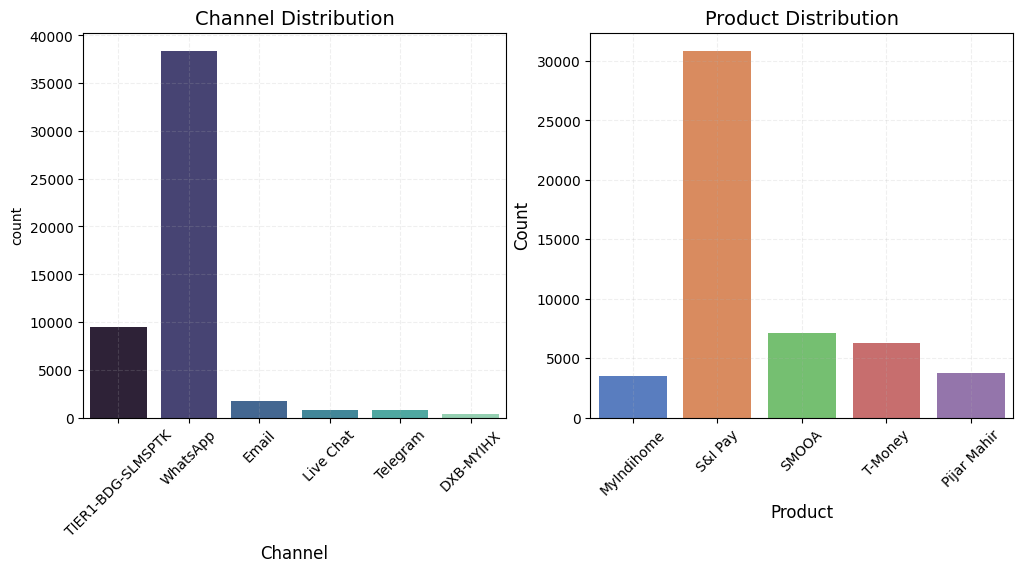

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='Channel', data=ori_df, palette="mako", ax=axes[0])
axes[0].set_title('Channel Distribution', fontsize = 14)
axes[0].set_xlabel('Channel', fontsize = 12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.2)

sns.countplot(x='Product', data=ori_df, palette="muted", ax=axes[1])
axes[1].set_title('Product Distribution', fontsize=14)
axes[1].set_xlabel('Product', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.2)

plt.show()

### Type and Source Distribution

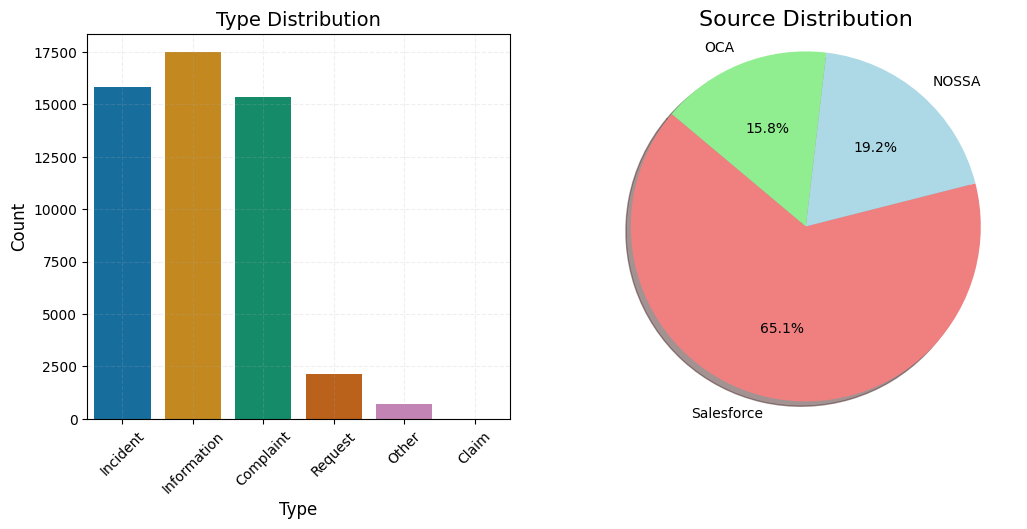

Information    0.339295
Incident       0.307488
Complaint      0.297992
Request        0.041574
Other          0.013535
Claim          0.000117
Name: Type, dtype: float64

In [ ]:
source_counts = ori_df['Source'].value_counts(normalize=True, dropna=False)
type_counts = ori_df['Type'].value_counts(normalize=True, dropna=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='Type', data=ori_df, palette="colorblind", ax=axes[0])
axes[0].set_title('Type Distribution', fontsize=14)
axes[0].set_xlabel('Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.2)

source_colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon']
source_labels = source_counts.index

axes[1].pie(source_counts, labels=source_labels, colors=source_colors, autopct='%1.1f%%', shadow=True, startangle=140)
axes[1].set_title('Source Distribution', fontsize=16)
axes[1].axis('equal')

plt.show()
type_counts

*Type distribution is not reflects the actual condition

### Uncorrect Status Distribution


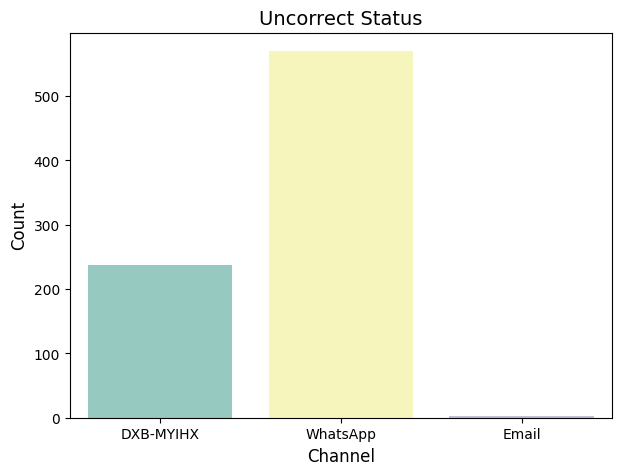

WhatsApp     0.703704
DXB-MYIHX    0.293827
Email        0.002469
Name: Channel, dtype: float64

In [ ]:
uncorrect_status_counts = whose_channel['Channel'].value_counts(normalize=True, dropna=False)

plt.figure(figsize=(7, 5))
sns.countplot(x='Channel', data=whose_channel, palette="Set3")
plt.title('Uncorrect Status', fontsize=14)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()
uncorrect_status_counts

## Multivariate

### Weekly Data

In [ ]:
weekly_data = ori_df.groupby(ori_df['Periode'].dt.to_period('W')).size().reset_index(name='Total_Data')
weekly_data.head()

,Periode,Total_Data
0,2022-12-26/2023-01-01,305
1,2023-01-02/2023-01-08,2059
2,2023-01-09/2023-01-15,1927
3,2023-01-16/2023-01-22,1482
4,2023-01-23/2023-01-29,1423


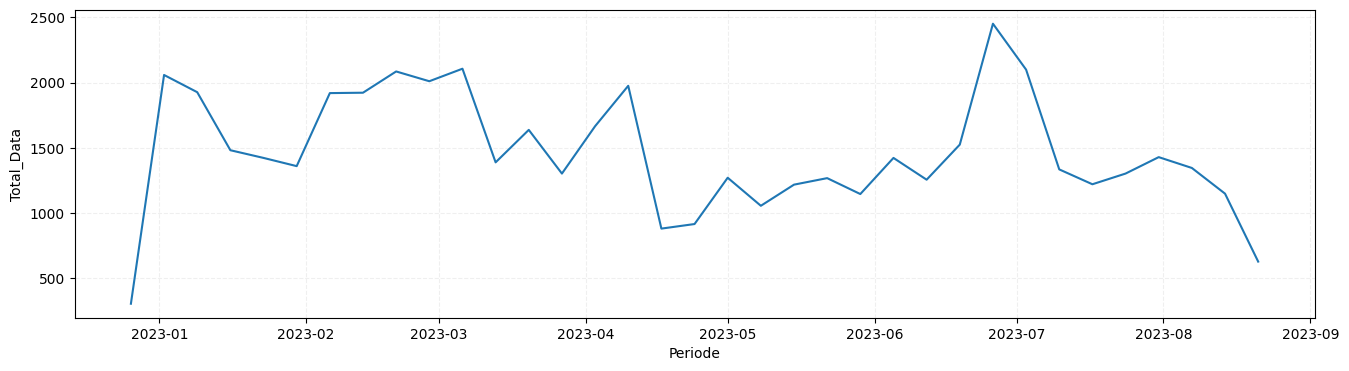

In [ ]:
weekly_data['Periode'] = weekly_data['Periode'].dt.to_timestamp()
weekly_data.set_index('Periode', inplace=True)

plt.figure(figsize=(16, 4))
sns.lineplot(data=weekly_data, x=weekly_data.index, y=weekly_data.Total_Data)
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

### Monthly Data

In [ ]:
monthly_data = ori_df.groupby(ori_df['Periode'].dt.to_period('M')).size().reset_index(name='Total_Data')
monthly_data

,Periode,Total_Data
0,2023-01,7569
1,2023-02,7721
2,2023-03,7419
3,2023-04,5663
4,2023-05,5392
5,2023-06,6493
6,2023-07,6918
7,2023-08,4323


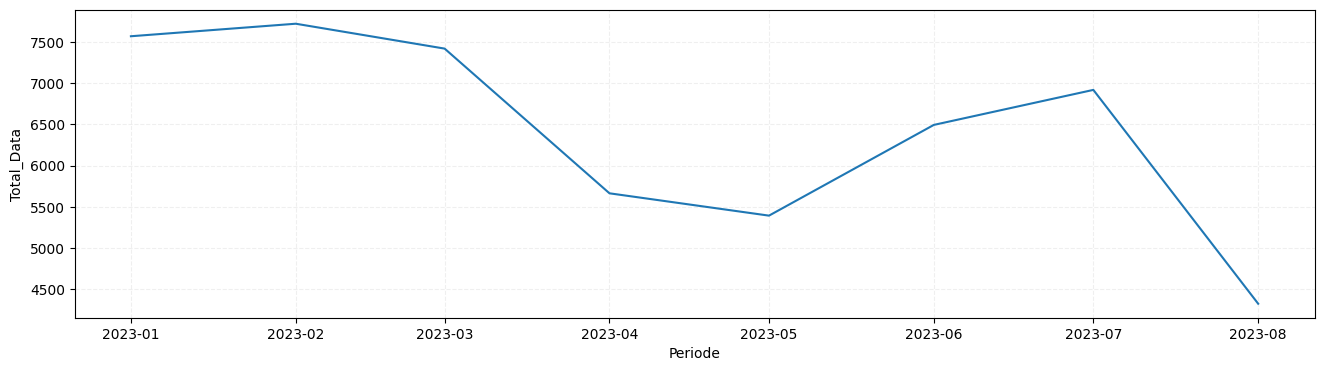

In [ ]:
monthly_data['Periode'] = monthly_data['Periode'].dt.to_timestamp()
monthly_data.set_index('Periode', inplace=True)

plt.figure(figsize=(16, 4))
sns.lineplot(data=monthly_data, x=monthly_data.index, y=monthly_data.Total_Data)
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

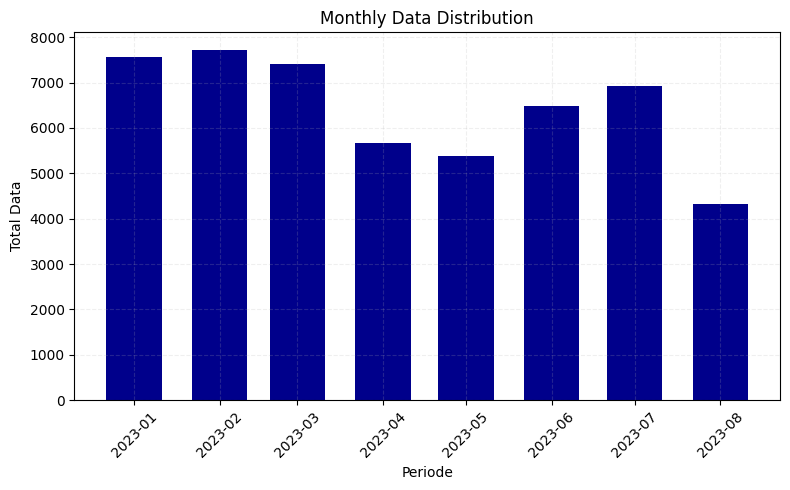

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(monthly_data.index, monthly_data['Total_Data'], width=20, align='center', color='darkblue')
plt.xlabel('Periode')
plt.ylabel('Total Data')
plt.title('Monthly Data Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

### Monthly Product Data Count

In [ ]:
product_counts = ori_df.groupby(['Year', 'Month', 'Product']).size().reset_index(name='Count')

In [ ]:
product_counts.head()

,Year,Month,Product,Count
0,2023,1,MyIndihome,510
1,2023,1,Pijar Mahir,170
2,2023,1,S&I Pay,3213
3,2023,1,SMOOA,2946
4,2023,1,T-Money,730


#### Barplot

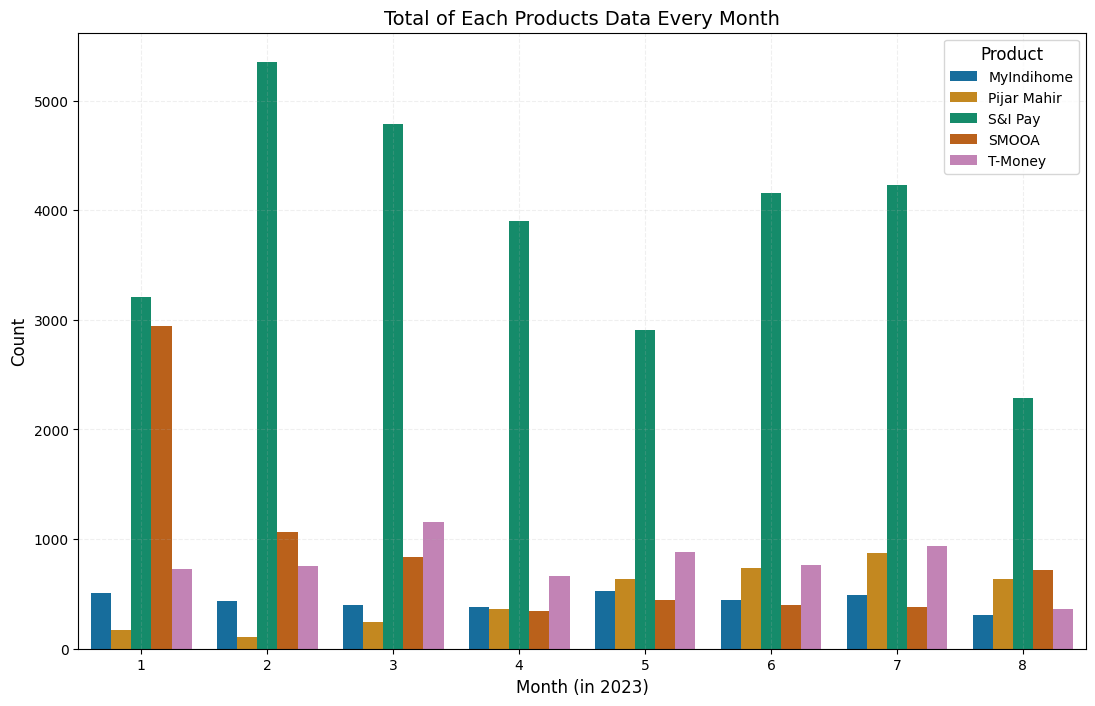

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(data=product_counts, x='Month', y='Count', hue='Product', palette='colorblind')
plt.title('Total of Each Products Data Every Month', fontsize=14)
plt.xlabel('Month (in 2023)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Product', title_fontsize='12')
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

#### Lineplot

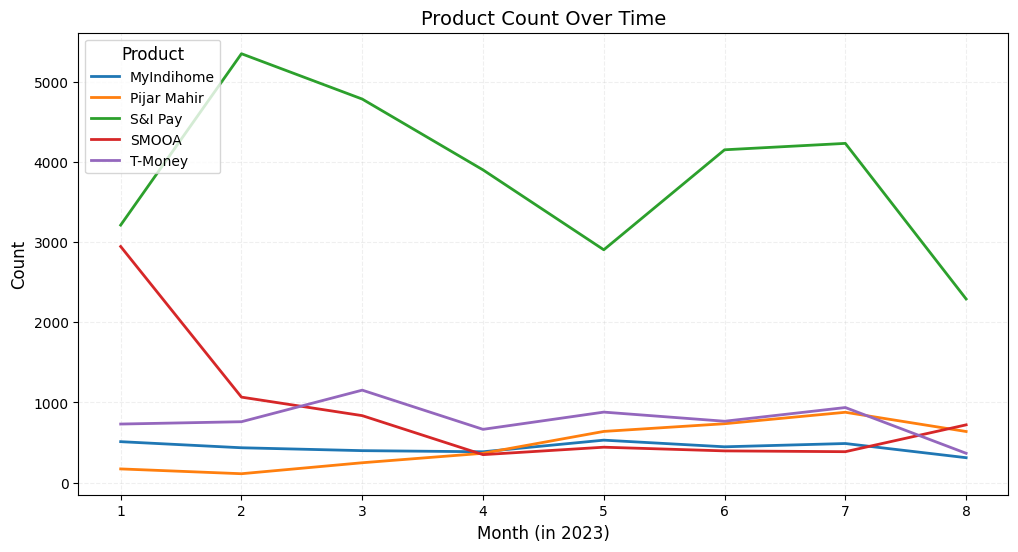

In [ ]:
plt.figure(figsize=(12, 6))

for product in product_counts['Product'].unique():
    product_data = product_counts[product_counts['Product'] == product]
    sns.lineplot(data=product_data, x='Month', y='Count', label=product, linewidth=2)

plt.title('Product Count Over Time', fontsize=14)
plt.xlabel('Month (in 2023)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Product', title_fontsize='12', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.2)

plt.show()

### Category vs 'Everybody'

In [ ]:
# Create functions for the visualization
def plot_stack1(data, colors, x_label=' ', y_label=' ', title=' '):
    percentage_data = (data.T * 100.0 / data.T.sum()).T
    ax = percentage_data.plot(kind='bar', width=0.3, stacked=True, rot=0, figsize=(10, 5), color=colors)

    plt.ylabel(f'{y_label}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.xlabel(f'{x_label}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.title(f'{title}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.legend(loc='upper right')
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.grid(True, linestyle='--', alpha=0.2)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height
        if percentage != 0:
            label_text = '{:.1f}%'.format(percentage)
            if percentage == 100:
                label_text = '100%'
            ax.text(x + width / 2,
                    y + height / 2,
                    label_text,
                    horizontalalignment='center',
                    verticalalignment='center')

    ax.autoscale(enable=False, axis='both', tight=False)
    plt.show()

def plot_stack2(data, x_label=' ', y_label=' ', title=' ', colors=None):
    ax = data.plot(kind='bar', width=0.3, stacked=True, rot=0, figsize=(10, 5), color=colors)

    plt.ylabel(f'{y_label}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.xlabel(f'{x_label}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.title(f'{title}\n', horizontalalignment="center", fontstyle="normal", fontfamily="sans-serif")
    plt.legend(loc='upper right')
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.grid(True, linestyle='--', alpha=0.2)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        label_text = f'{height:.2f}'
        ax.text(x + width / 2,
                y + height / 2,
                label_text,
                horizontalalignment='center',
                verticalalignment='center')

    ax.autoscale(enable=False, axis='both', tight=False)
    plt.show()

#### Category vs Product

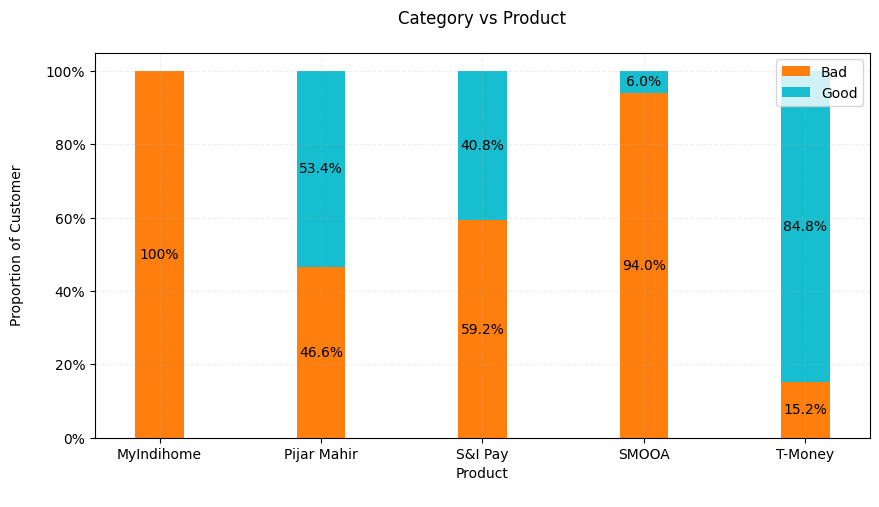

In [ ]:
# Category Product
category_product = ori_df.groupby(['Product','Category']).size().unstack()
category_product.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(category_product, colors, y_label='Proportion of Customer', x_label='Product', title='Category vs Product')

#### Category vs Status

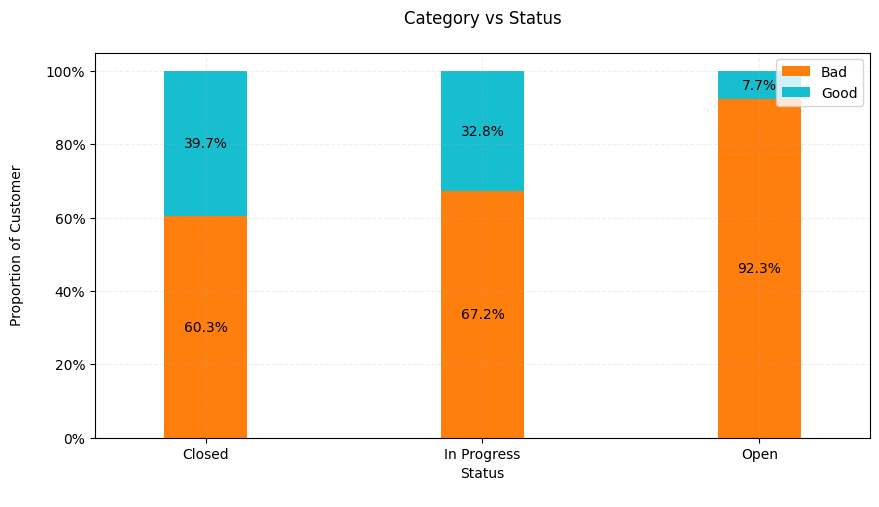

In [ ]:
# Category Status
category_status = ori_df.groupby(['Status','Category']).size().unstack()
category_status.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(category_status, colors, y_label='Proportion of Customer', x_label='Status', title='Category vs Status')

#### Category vs Channel

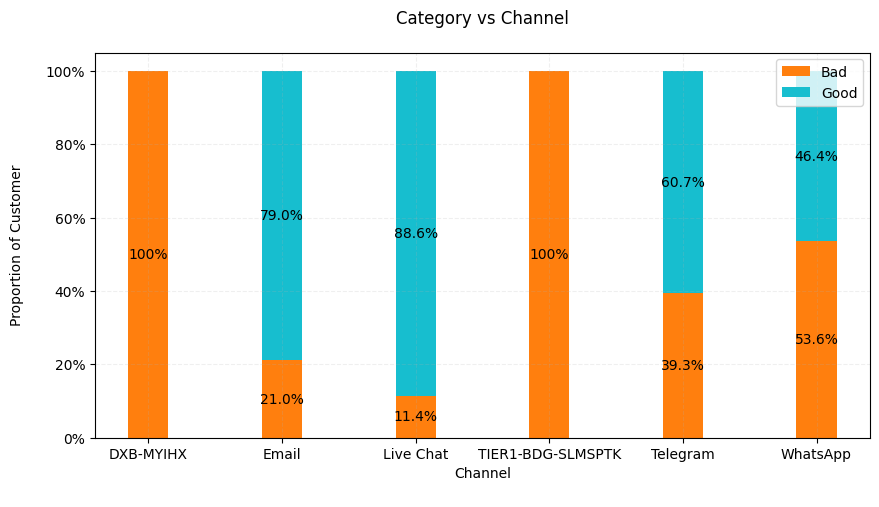

In [ ]:
category_channel = ori_df.groupby(['Channel','Category']).size().unstack()
category_channel.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(category_channel, colors, y_label='Proportion of Customer', x_label='Channel', title='Category vs Channel')

#### Category vs Month

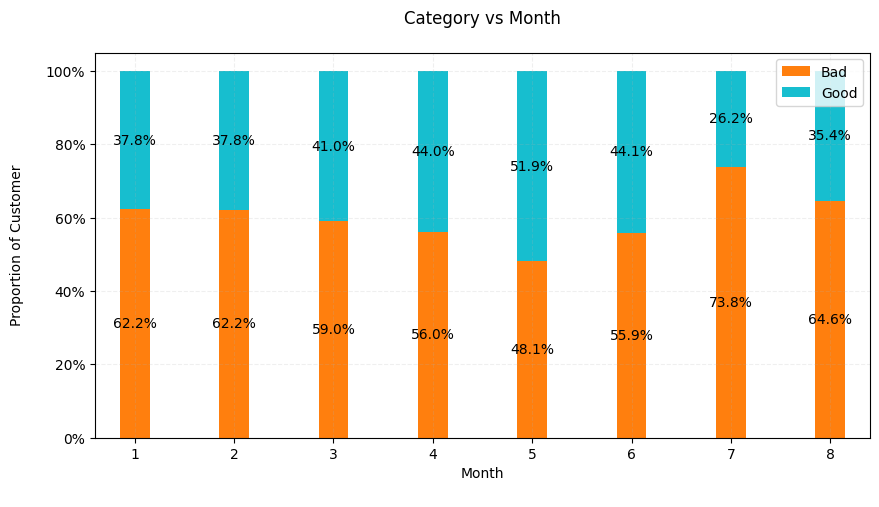

In [ ]:
category_month = ori_df.groupby(['Month','Category']).size().unstack()
category_month.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(category_month, colors, y_label='Proportion of Customer', x_label='Month', title='Category vs Month')

#### Category vs Product vs Month

In [ ]:
category_month_df = ori_df.pivot_table(ori_df, index=['Year', 'Month', 'Product'], columns='Category', aggfunc='size', fill_value=0)
category_month_df.columns = ['Bad', 'Good']
category_month_df.reset_index(inplace=True)

In [ ]:
# Count
category_month_df.head()

,Year,Month,Product,Bad,Good
0,2023,1,MyIndihome,510,0
1,2023,1,Pijar Mahir,48,122
2,2023,1,S&I Pay,1428,1785
3,2023,1,SMOOA,2610,336
4,2023,1,T-Money,112,618


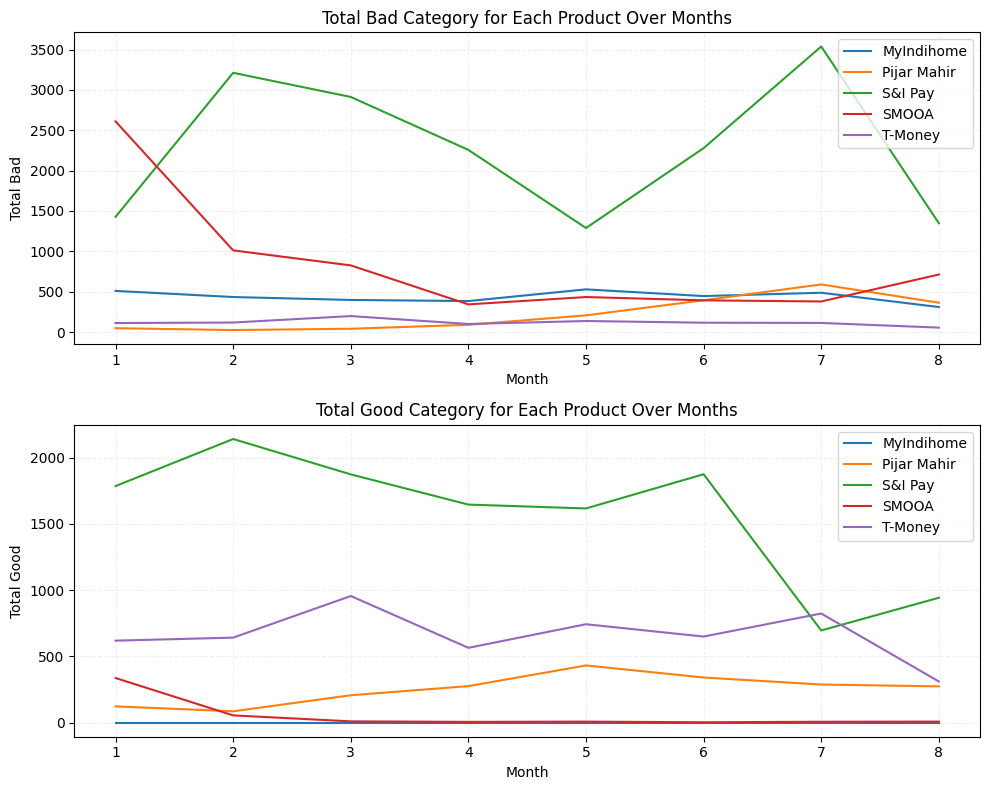

In [ ]:
monthly_totals = category_month_df.groupby(['Month', 'Product'])[['Bad', 'Good']].sum().reset_index()
monthly_counts = category_month_df.groupby(['Month', 'Product'])['Bad'].count().reset_index()

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
for product in monthly_totals['Product'].unique():
    product_data = monthly_totals[monthly_totals['Product'] == product]
    plt.plot(product_data['Month'], product_data['Bad'], label=product)
plt.title('Total Bad Category for Each Product Over Months')
plt.xlabel('Month')
plt.ylabel('Total Bad')
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()

plt.subplot(2, 1, 2)
for product in monthly_totals['Product'].unique():
    product_data = monthly_totals[monthly_totals['Product'] == product]
    plt.plot(product_data['Month'], product_data['Good'], label=product)
plt.title('Total Good Category for Each Product Over Months')
plt.xlabel('Month')
plt.ylabel('Total Good')
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # Count
# df_category_product = category_month_df.groupby(['Month', 'Product'])[['Bad', 'Good']].sum().reset_index()
# df_category_product = pd.DataFrame(df_category_product)
# df_category_product.head()

# Human Resource Planning & Improve Customer Experience Analysis

## Additional Cleaning

karena berkaitan dengan resolved time yang tidak subjektif, maka dibuat New DF, Whatsapp di bawah 81 detik, berdasarkan Live Chat, karena new df, export semua column


In [ ]:
# Delete WhatsApp value in the Channel column that has ResolvedTime_Second less than 81 seconds
cleaned_df = ori_df[~((ori_df['Channel'] == 'WhatsApp') & ((ori_df['Type'] == 'Incident') | (ori_df['Type'] == 'Complaint')) & (ori_df['ResolvedTime_Second'] < 81))]

In [ ]:
cleaned_df.tail()

,Source,Periode,CaseNumber,Product,Status,Symptom,Channel,Type,ClosedDate,ResolvedTime_Second,Category,Year,Month
51493,Salesforce,2023-08-23 13:24:57,1734157,S&I Pay,Closed,saldo belum masuk ke pendapatan,WhatsApp,Information,2023-08-23 13:25:02,5.000000,1,2023,8
51494,Salesforce,2023-08-23 13:44:35,1734159,T-Money,Closed,tentang tmoney,WhatsApp,Information,2023-08-23 13:44:53,18.000000,1,2023,8
51495,Salesforce,2023-08-23 13:45:49,1734161,T-Money,In Progress,info pin,WhatsApp,Information,2023-08-24 06:37:18,60689.032272,1,2023,8
51496,Salesforce,2023-08-23 13:53:51,1734163,T-Money,Open,gagal topup pulsa (akses dari mobile),WhatsApp,Information,2023-08-24 06:45:20,60689.032272,1,2023,8
51497,Salesforce,2023-08-23 13:57:28,1734164,T-Money,In Progress,info upgrade akun,WhatsApp,Information,2023-08-24 06:48:57,60689.032272,1,2023,8


## Time To Resolution (TTR)

### ResolvedTime_Second Mean by Product and Category

In [ ]:
# Average total ResolvedTime_Second by Categoty for each product
average_product_category = cleaned_df.groupby(['Product', 'Category'])['ResolvedTime_Second'].mean().reset_index()
average_product_category = average_product_category.rename(columns={'ResolvedTime_Second': 'Mean_ResolvedTime_Second'})
average_product_category

,Product,Category,Mean_ResolvedTime_Second
0,MyIndihome,0,7614.943917
1,Pijar Mahir,0,23614.178259
2,Pijar Mahir,1,17983.817413
3,S&I Pay,0,207132.441368
4,S&I Pay,1,93014.764774
5,SMOOA,0,12826.639188
6,SMOOA,1,9951.936620
7,T-Money,0,237152.069800
8,T-Money,1,44974.563744


### ResolvedTime_Second Mean by the Top 5 Fastest and Slowest Symptoms

In [ ]:
# Top 5 fastest and slowest Symptoms (General)
average_top_5_symptoms = cleaned_df.groupby(['Product', 'Symptom'])['ResolvedTime_Second'].mean().reset_index()
average_top_5_symptoms = average_top_5_symptoms.rename(columns={'ResolvedTime_Second': 'Mean_ResolvedTime_Second'})
average_top_5_symptoms

,Product,Symptom,Mean_ResolvedTime_Second
0,MyIndihome,failed to login hbo go,7939.000000
1,MyIndihome,gagal aktivasi renew speed,12280.900036
2,MyIndihome,gagal aktivasi speed on demand,14329.244898
3,MyIndihome,gagal aktivasi upgrade speed,31755.000000
4,MyIndihome,gagal aktivasi wifi.id seamless,11365.795294
...,...,...,...
287,T-Money,unblock akun,50008.425170
288,T-Money,upgrade akun,37942.461837
289,T-Money,user tidak merespon,52783.966667
290,T-Money,verifikasi no.hp,59880.404857


In [ ]:
# Identify the symptom category
average_top_5_symptoms['Count'] = 0

for symptom in average_top_5_symptoms['Symptom']:
    count = (cleaned_df['Symptom'] == symptom).sum()
    average_top_5_symptoms.loc[average_top_5_symptoms['Symptom'] == symptom, 'Count'] = count

category_counts = cleaned_df.groupby(['Symptom', 'Category'])['Category'].count().unstack(fill_value=0)
average_top_5_symptoms = average_top_5_symptoms.merge(category_counts, on='Symptom', how='left')
average_top_5_symptoms = average_top_5_symptoms.rename(columns={0: 'Total_Category_0', 1: 'Total_Category_1'})

average_top_5_symptoms

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
0,MyIndihome,failed to login hbo go,7939.000000,1,1,0
1,MyIndihome,gagal aktivasi renew speed,12280.900036,165,165,0
2,MyIndihome,gagal aktivasi speed on demand,14329.244898,49,49,0
3,MyIndihome,gagal aktivasi upgrade speed,31755.000000,1,1,0
4,MyIndihome,gagal aktivasi wifi.id seamless,11365.795294,35,35,0
...,...,...,...,...,...,...
287,T-Money,unblock akun,50008.425170,233,50,183
288,T-Money,upgrade akun,37942.461837,828,201,627
289,T-Money,user tidak merespon,52783.966667,141,0,141
290,T-Money,verifikasi no.hp,59880.404857,89,11,78


In [ ]:
# Top 5 Symptom (General)
sorted_top_5_symptom = average_top_5_symptoms.sort_values(by='Mean_ResolvedTime_Second')

top_5_fastest_symptoms = sorted_top_5_symptom.head(5)
top_5_slowest_symptoms = sorted_top_5_symptom.tail(5)

In [ ]:
# Top 5 fastest
top_5_fastest_symptoms

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
33,Pijar Mahir,gateway tidak online,5.000000,1,0,1
58,Pijar Mahir,tidak ada video yang tersimpan,6.000000,1,0,1
29,Pijar Mahir,froce close,7.000000,1,0,1
199,SMOOA,aplikasi smooa tidak ditemukan di playstore an...,50.000000,1,0,1
210,SMOOA,gagal login smooa,219.928571,14,3,11


In [ ]:
# Top 5 slowest
top_5_slowest_symptoms

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
85,S&I Pay,claim issuer,5.609396e+05,37,27,10
257,T-Money,gagal pay by qr,6.183828e+05,14,11,3
175,S&I Pay,tarik tunai sooltanpay,7.126599e+05,854,594,260
174,S&I Pay,tagihan pln,1.025190e+06,2,2,0
282,T-Money,perubahan bisnis proses,3.369622e+06,1,1,0


In [ ]:
# Check the duplicate symptoms in the same product
duplicate_symptoms = sorted_top_5_symptom[sorted_top_5_symptom.duplicated(subset=['Symptom'], keep=False)]
print("Duplicate Symptoms:")
print(duplicate_symptoms)

Duplicate Symptoms:
         Product              Symptom  Mean_ResolvedTime_Second  Count  \
49   Pijar Mahir     notifikasi email               1052.283019    128   
34   Pijar Mahir             greeting               2239.461538    177   
68   Pijar Mahir  user tidak merespon               3106.380952    141   
129      S&I Pay     notifikasi email               3206.640000    128   
171      S&I Pay                 spam               4052.727072   1068   
55   Pijar Mahir                 spam               4501.064662   1068   
106      S&I Pay          info produk               4678.230769    196   
192      S&I Pay      user not respon               5279.180676    431   
94       S&I Pay             greeting               6354.584000    177   
65   Pijar Mahir      user not respon               6564.112500    431   
38   Pijar Mahir          info produk               9280.993727    196   
43   Pijar Mahir              lainnya               9513.719524    635   
120      S&I Pay  

#### Pijar Mahir

In [ ]:
# Top 5 Fastest and Slowest Symptoms (Pijar Mahir)
pijar_mahir_display = 'Pijar Mahir'
pijar_mahir_symptom = sorted_top_5_symptom[sorted_top_5_symptom['Product'] == pijar_mahir_display]

In [ ]:
# Symptoms that have a little number of case
pijar_mahir_symptom_rare = pijar_mahir_symptom[pijar_mahir_symptom['Count'] <= 8]

In [ ]:
pijar_mahir_symptom.drop(pijar_mahir_symptom_rare.index, inplace=True)

<ipython-input-94-0582e82a70af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pijar_mahir_symptom.drop(pijar_mahir_symptom_rare.index, inplace=True)


In [ ]:
top_5_fastest_pijar_mahir = pijar_mahir_symptom.head(5)
top_5_slowest_pijar_mahir = pijar_mahir_symptom.tail(5)

In [ ]:
top_5_fastest_pijar_mahir

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
49,Pijar Mahir,notifikasi email,1052.283019,128,128,0
34,Pijar Mahir,greeting,2239.461538,177,177,0
68,Pijar Mahir,user tidak merespon,3106.380952,141,0,141
40,Pijar Mahir,info sertifikat,4308.790619,145,0,145
55,Pijar Mahir,spam,4501.064662,1068,1068,0


In [ ]:
top_5_slowest_pijar_mahir

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
60,Pijar Mahir,tidak bisa pembayaran via kartu prakerja,48252.077245,109,80,29
59,Pijar Mahir,tidak bisa download sertifikat,48482.655150,33,27,6
57,Pijar Mahir,"sudah selesai pelatihan, sertifikat tidak munc...",139429.780285,70,37,33
52,Pijar Mahir,saldo terpotong tapi tidak bisa mengikuti pela...,146087.675553,9,9,0
42,Pijar Mahir,kode voucher tidak sesuai,278455.325882,17,11,6


#### S&I Pay

In [ ]:
# Top 5 fastest and slowest Symptoms (S&I Pay)
s_and_i_pay_display = 'S&I Pay'
s_and_i_pay_symptom = sorted_top_5_symptom[sorted_top_5_symptom['Product'] == s_and_i_pay_display]
top_5_fastest_s_and_i_pay = s_and_i_pay_symptom.head(5)
top_5_slowest_s_and_i_pay = s_and_i_pay_symptom.tail(5)

In [ ]:
# Symptoms that have a small number of case
s_and_i_pay_symptom_rare = s_and_i_pay_symptom[s_and_i_pay_symptom['Count'] <= 8]

In [ ]:
s_and_i_pay_symptom.drop(s_and_i_pay_symptom_rare.index, inplace=True)

<ipython-input-100-9ab9565e0f71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_and_i_pay_symptom.drop(s_and_i_pay_symptom_rare.index, inplace=True)


In [ ]:
top_5_fastest_s_and_i_pay = s_and_i_pay_symptom.head(5)
top_5_slowest_s_and_i_pay = s_and_i_pay_symptom.tail(5)

In [ ]:
top_5_fastest_s_and_i_pay

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
125,S&I Pay,maintenance,660.050000,40,40,0
158,S&I Pay,saldo masih dalam proses,2583.000000,10,10,0
129,S&I Pay,notifikasi email,3206.640000,128,128,0
134,S&I Pay,otp tidak masuk,3491.606061,33,33,0
80,S&I Pay,bug sooltanpay,3992.117647,17,17,0


In [ ]:
top_5_slowest_s_and_i_pay

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
77,S&I Pay,atur produk,319338.727273,11,6,5
140,S&I Pay,pergantian no hp,335009.445652,92,22,70
184,S&I Pay,transaksi tidak tercatat di riwayat aplikasi,365431.215080,19,19,0
85,S&I Pay,claim issuer,560939.578846,37,27,10
175,S&I Pay,tarik tunai sooltanpay,712659.855695,854,594,260


#### T-Money

In [ ]:
# Top 5 fastest and slowest Symptoms (T-Money)
t_money_display = 'T-Money'
t_money_symptom = sorted_top_5_symptom[sorted_top_5_symptom['Product'] == t_money_display]

In [ ]:
# Symptoms that have a small number of case
t_money_symptom_rare = t_money_symptom[t_money_symptom['Count'] <= 8]

In [ ]:
t_money_symptom.drop(t_money_symptom_rare.index, inplace=True)

<ipython-input-106-6d3d93780e74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_money_symptom.drop(t_money_symptom_rare.index, inplace=True)


In [ ]:
top_5_fastest_t_money = t_money_symptom.head(5)
top_5_slowest_t_money = t_money_symptom.tail(5)

In [ ]:
top_5_fastest_t_money

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
273,T-Money,info redeem poin,10818.035948,306,0,306
286,T-Money,tentang tmoney,24242.851818,283,14,269
277,T-Money,info upgrade akun,24539.441780,1130,0,1130
271,T-Money,info password,26985.239024,410,0,410
272,T-Money,info pin,32266.476427,273,0,273


In [ ]:
top_5_slowest_t_money

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
267,T-Money,gagal transaksi p2b (akses dari web),261380.066667,15,13,2
253,T-Money,cashout saldo (pensiunan),316627.952171,58,9,49
265,T-Money,gagal topup saldo va,397957.382992,55,44,11
266,T-Money,gagal transaksi p2b (akses dari mobile),481774.868651,181,160,21
257,T-Money,gagal pay by qr,618382.788019,14,11,3


#### SMOOA

In [ ]:
# Top 5 fastest and slowest Symptoms (SMOOA)
SMOOA_display = 'SMOOA'
SMOOA_symptom = sorted_top_5_symptom[sorted_top_5_symptom['Product'] == SMOOA_display]

In [ ]:
# Symptoms that have a small number of case
SMOOA_symptom_rare = SMOOA_symptom[SMOOA_symptom['Count'] <= 8]

In [ ]:
SMOOA_symptom.drop(SMOOA_symptom_rare.index, inplace=True)

<ipython-input-112-12d92f09f7c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SMOOA_symptom.drop(SMOOA_symptom_rare.index, inplace=True)


In [ ]:
top_5_fastest_SMOOA = SMOOA_symptom.head(5)
top_5_slowest_SMOOA = SMOOA_symptom.tail(5)

In [ ]:
top_5_fastest_SMOOA

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
210,SMOOA,gagal login smooa,219.928571,14,3,11
211,SMOOA,gagal melakukan pembayaran,930.333333,12,3,9
218,SMOOA,gagal renewal muncul kode keterangan error ok05,2360.250000,16,16,0
206,SMOOA,gagal edit member,3239.250000,16,16,0
237,SMOOA,quota sms member tidak muncul,3884.500000,12,9,3


In [ ]:
top_5_slowest_SMOOA

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
234,SMOOA,quota cug parent tidak muncul,20998.333333,9,9,0
241,SMOOA,quota tsel parent tidak muncul,21180.473684,57,50,7
240,SMOOA,quota tsel member tidak muncul,21479.294983,81,72,9
209,SMOOA,gagal login,24311.093192,892,892,0
203,SMOOA,gagal daftar smooa melalui frontliner via sc (...,30322.571429,14,14,0


#### MyIndihome

In [ ]:
# Top 5 fastest and slowest Symptoms (MyIndihome)
MyIndihome_display = 'MyIndihome'
MyIndihome_symptom = sorted_top_5_symptom[sorted_top_5_symptom['Product'] == MyIndihome_display]

In [ ]:
# Symptoms that have a small number of case
MyIndihome_symptom_rare = MyIndihome_symptom[MyIndihome_symptom['Count'] <= 8]

In [ ]:
MyIndihome_symptom.drop(MyIndihome_symptom_rare.index, inplace=True)

<ipython-input-118-a2d5ec5e578d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MyIndihome_symptom.drop(MyIndihome_symptom_rare.index, inplace=True)


In [ ]:
top_5_fastest_MyIndihome = MyIndihome_symptom.head(5)
top_5_slowest_MyIndihome = MyIndihome_symptom.tail(5)

In [ ]:
top_5_fastest_MyIndihome

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
9,MyIndihome,gagal mendapatkan jadwal teknisi,2638.923077,26,26,0
23,MyIndihome,permintaan pengaktifkan akun mihx,5682.826585,308,308,0
20,MyIndihome,permintaan cabut portofolio,5718.382169,384,384,0
26,MyIndihome,tidak mendapatkan kode verifikasi otp,5915.253907,280,280,0
19,MyIndihome,permintaan bantu edit contact person akun mihx,6003.754945,458,458,0


In [ ]:
top_5_slowest_MyIndihome

,Product,Symptom,Mean_ResolvedTime_Second,Count,Total_Category_0,Total_Category_1
2,MyIndihome,gagal aktivasi speed on demand,14329.244898,49,49,0
13,MyIndihome,gagal upgrade speed dari mihx,14677.000000,9,9,0
15,MyIndihome,gagal verikasi lokasi,15932.904762,21,21,0
16,MyIndihome,gagal verikasi nomor identitas,17725.779028,23,23,0
24,MyIndihome,point reward tidak bertambah,24941.858353,50,50,0


### Category ResolvedTime_Second Mean

In [ ]:
# Category by ResolvedTime_Second
mean_time_per_category = cleaned_df.groupby('Category')['ResolvedTime_Second'].mean()
mean_time_per_category = pd.DataFrame(mean_time_per_category)
mean_time_per_category

,ResolvedTime_Second
Category,
0,120302.168210
1,71280.188145


## Frequency and Severity

In [ ]:
# Create a new df name
busy_days = cleaned_df.copy()

In [ ]:
busy_days

,Source,Periode,CaseNumber,Product,Status,Symptom,Channel,Type,ClosedDate,ResolvedTime_Second,Category,Year,Month
0,NOSSA,2023-01-01 00:13:06,IN156664075,MyIndihome,Closed,gagal redeem point,TIER1-BDG-SLMSPTK,Incident,2023-01-01 16:08:08,57302.000000,0,2023,1
1,NOSSA,2023-01-01 00:14:32,IN156664077,MyIndihome,Closed,gagal mapping nomor indihome pelanggan,TIER1-BDG-SLMSPTK,Incident,2023-01-01 08:35:27,30055.000000,0,2023,1
2,Salesforce,2023-01-01 00:17:55,1658908,S&I Pay,Closed,info upgrade akun sooltanpay,WhatsApp,Information,2023-01-01 00:30:10,735.000000,1,2023,1
3,Salesforce,2023-01-01 00:52:10,1658910,S&I Pay,Closed,topup e wallet,WhatsApp,Complaint,2023-01-01 01:01:26,556.000000,0,2023,1
4,NOSSA,2023-01-01 01:04:06,IN156664579,SMOOA,Closed,gagal login,TIER1-BDG-SLMSPTK,Incident,2023-01-01 08:43:30,27564.000000,0,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51493,Salesforce,2023-08-23 13:24:57,1734157,S&I Pay,Closed,saldo belum masuk ke pendapatan,WhatsApp,Information,2023-08-23 13:25:02,5.000000,1,2023,8
51494,Salesforce,2023-08-23 13:44:35,1734159,T-Money,Closed,tentang tmoney,WhatsApp,Information,2023-08-23 13:44:53,18.000000,1,2023,8
51495,Salesforce,2023-08-23 13:45:49,1734161,T-Money,In Progress,info pin,WhatsApp,Information,2023-08-24 06:37:18,60689.032272,1,2023,8
51496,Salesforce,2023-08-23 13:53:51,1734163,T-Money,Open,gagal topup pulsa (akses dari mobile),WhatsApp,Information,2023-08-24 06:45:20,60689.032272,1,2023,8


In [ ]:
product_means = busy_days.groupby('Product')['ResolvedTime_Second'].mean().reset_index()
product_means.rename(columns={'ResolvedTime_Second': 'ProductMean'}, inplace=True)

In [ ]:
busy_days = busy_days.merge(product_means, on='Product', how='left')

In [ ]:
# Make the diff
busy_days['TimeDifference'] = busy_days['ResolvedTime_Second'] - busy_days['ProductMean']

In [ ]:
# Delete the outlier which 3x than the std
std_multiplier = 3
outlier_threshold = std_multiplier * busy_days['TimeDifference'].std()

In [ ]:
data_cleaned = busy_days[abs(busy_days['TimeDifference']) <= outlier_threshold]

In [ ]:
# Drop and assign to busy_days dataframe
columns_to_drop = ['ProductMean', 'TimeDifference']
busy_days = data_cleaned.drop(columns=columns_to_drop)

In [ ]:
# Create days name
busy_days['DayOfWeek'] = cleaned_df['Periode'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

### The Most Symptom Value


In [ ]:
top_symptoms = busy_days['Symptom'].value_counts()
top_10_symptoms = top_symptoms.head(10)

print(top_10_symptoms)

saldo belum masuk ke pendapatan                                         8464
info upgrade akun sooltanpay                                            2654
upgrade akun sooltanpay                                                 2175
akun sooltanpay terblokir                                               1437
info sppd                                                               1277
info upgrade akun                                                       1127
spam                                                                    1068
paket smooa tidak diperbarui padahal sudah lebih dari jadwal renewal    1045
info pelatihan                                                           927
topup e wallet                                                           926
Name: Symptom, dtype: int64


In [ ]:
top_10_symptoms = pd.DataFrame(top_10_symptoms)
top_10_symptoms

,Symptom
saldo belum masuk ke pendapatan,8464
info upgrade akun sooltanpay,2654
upgrade akun sooltanpay,2175
akun sooltanpay terblokir,1437
info sppd,1277
info upgrade akun,1127
spam,1068
paket smooa tidak diperbarui padahal sudah lebih dari jadwal renewal,1045
info pelatihan,927
topup e wallet,926


### Day Analysis

In [ ]:
busy_days['Day'] = busy_days['Periode'].dt.strftime('%A')

#### Resolved time mean per day

In [ ]:
# # ResolvedTime_Second mean each day
# RTS_day = busy_days.groupby('DayOfWeek').agg({'Periode': 'count', 'ResolvedTime_Second': 'mean'})
# RTS_day = RTS_day.reindex(day_order)

In [ ]:
busy_days['DayOfWeek'] = busy_days['Periode'].dt.dayofweek
rts_day = busy_days.groupby('DayOfWeek').agg({'ResolvedTime_Second': 'mean', 'Periode': 'count'})
rts_day.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rts_day.columns = ['ResolvedTime_Second Mean', 'Count']
rts_day = rts_day.reindex(day_order)

print(rts_day)

           ResolvedTime_Second Mean  Count
Monday                 38671.171272   9611
Tuesday                50881.052622   7955
Wednesday              69719.417089   6721
Thursday               56122.150858   6302
Friday                 59007.708876   6374
Saturday               61537.568029   4419
Sunday                 49865.567313   4264


#### Estimated unfinished ticket/case each day

In [ ]:
# Total Period and ClosedDate
period_counts = busy_days['Periode'].dt.day_name().value_counts().rename('PeriodCount')
closed_date_counts = busy_days['ClosedDate'].dt.day_name().value_counts().rename('ClosedDateCount')

# Unfinished
unfinished_day = pd.concat([period_counts, closed_date_counts], axis=1)
unfinished_day = unfinished_day.reindex(day_order, fill_value=0)
unfinished_day['Diff'] = unfinished_day['PeriodCount'] - unfinished_day['ClosedDateCount']

print(unfinished_day)

           PeriodCount  ClosedDateCount  Diff
Monday            9611             9285   326
Tuesday           7955             8066  -111
Wednesday         6721             6849  -128
Thursday          6302             6362   -60
Friday            6374             6473   -99
Saturday          4419             4298   121
Sunday            4264             4313   -49


In [ ]:
# Total of Data
count_sum_period = unfinished_day['PeriodCount'].sum()
count_sum_closed = unfinished_day['ClosedDateCount'].sum()

print('Total of Period count:', count_sum_period)
print('Total of Closed Date count:',count_sum_closed)

Total of Period count: 45646
Total of Closed Date count: 45646


#### Estimated number of actual cases worked on each day

In [ ]:
# Estimation
estimated_actual_case = unfinished_day.drop(columns=['Diff'])
remainder = 0

for index, row in estimated_actual_case.iterrows():
    period_count = row['PeriodCount']
    closed_date_count = row['ClosedDateCount']
    period_count += remainder
    diff = period_count - closed_date_count
    remainder = diff
    estimated_actual_case.at[index, 'ClosedDateCount'] = 0
    estimated_actual_case.at[index, 'PeriodCount'] = period_count

estimated_actual_case = estimated_actual_case.drop(columns=['ClosedDateCount'])
estimated_actual_case = estimated_actual_case.rename(columns={'PeriodCount': 'Estimated Total Case'})

print(estimated_actual_case)

           Estimated Total Case
Monday                     9611
Tuesday                    8281
Wednesday                  6936
Thursday                   6389
Friday                     6401
Saturday                   4347
Sunday                     4313


#### Each product on each day

In [ ]:
# Product Case by Day
products = ['MyIndihome', 'Pijar Mahir', 'S&I Pay', 'SMOOA', 'T-Money']
product_counts = busy_days[busy_days['Product'].isin(products)].groupby(['Day', 'Product'])['Product'].count().unstack(fill_value=0)
product_counts = product_counts.reindex(day_order)

print(product_counts)

Product    MyIndihome  Pijar Mahir  S&I Pay  SMOOA  T-Money
Day                                                        
Monday            541          867     5695   1370     1138
Tuesday           523          554     4694   1052     1132
Wednesday         494          518     3550   1137     1022
Thursday          500          530     3334   1043      895
Friday            545          460     3394   1098      877
Saturday          461          351     2344    741      522
Sunday            434          293     2403    666      468


#### Estimated Product and Category on each day

In [ ]:
# Product and Category by day
counted_category = busy_days['Category'].unique()
product_category_counts = busy_days[busy_days['Product'].isin(products) & df['Category'].isin(counted_category)].groupby(['Day', 'Product', 'Category'])['Product'].count().unstack(fill_value=0)

print(product_category_counts)

Category                  0     1
Day       Product                
Friday    MyIndihome    545     0
          Pijar Mahir   197   263
          S&I Pay      1635  1759
          SMOOA        1030    67
          T-Money       133   744
Monday    MyIndihome    541     0
          Pijar Mahir   375   492
          S&I Pay      3168  2526
          SMOOA        1290    80
          T-Money       142   996
Saturday  MyIndihome    461     0
          Pijar Mahir   145   206
          S&I Pay      1098  1246
          SMOOA         727    13
          T-Money        66   456
Sunday    MyIndihome    434     0
          Pijar Mahir   126   167
          S&I Pay      1172  1231
          SMOOA         657     9
          T-Money        63   405
Thursday  MyIndihome    500     0
          Pijar Mahir   251   279
          S&I Pay      1613  1721
          SMOOA         961    82
          T-Money       117   778
Tuesday   MyIndihome    523     0
          Pijar Mahir   249   305
          S&I 

<ipython-input-141-bcbf08e64b10>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  product_category_counts = busy_days[busy_days['Product'].isin(products) & df['Category'].isin(counted_category)].groupby(['Day', 'Product', 'Category'])['Product'].count().unstack(fill_value=0)


#### Unfinished case estimation for Product and Category on each day

In [ ]:
# Unfinished Case by Category and Product
busy_days['TimePeriod'] = busy_days['ClosedDate'] - busy_days['Periode']
busy_days['DayOfWeek_Period'] = busy_days['Periode'].dt.day_name()

# Filter: TimePeriod > 1 day
time_period_more_than_one = busy_days[busy_days['TimePeriod'] > pd.Timedelta(days=1)]

time_period_more_than_one = time_period_more_than_one.groupby(['DayOfWeek_Period', 'Product', 'Category']).size().reset_index(name='Count')

unfinished_category_product = time_period_more_than_one.pivot_table(index=['DayOfWeek_Period', 'Product'], columns='Category', values='Count', fill_value=0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
unfinished_category_product = unfinished_category_product.reindex(index=pd.MultiIndex.from_product([days_order, unfinished_category_product.index.levels[1]]))

print(unfinished_category_product)

Category                 0    1
          Product              
Monday    MyIndihome     4    0
          Pijar Mahir    0    9
          S&I Pay      526  226
          SMOOA         52    4
          T-Money       43   66
Tuesday   MyIndihome     4    0
          Pijar Mahir    3    3
          S&I Pay      494  259
          SMOOA         17    4
          T-Money       31   64
Wednesday MyIndihome     7    0
          Pijar Mahir    5    6
          S&I Pay      519  240
          SMOOA         26    0
          T-Money       35   84
Thursday  MyIndihome     3    0
          Pijar Mahir    2    3
          S&I Pay      404  200
          SMOOA         21    1
          T-Money       41   72
Friday    MyIndihome     7    0
          Pijar Mahir    1    7
          S&I Pay      427  236
          SMOOA         16    2
          T-Money       34   60
Saturday  MyIndihome     3    0
          Pijar Mahir    1    5
          S&I Pay      351  201
          SMOOA         12    0
        

#### ResolvedTime_Second mean for unfinished case by Product and Category on each day

In [ ]:
# Unfinished Case by Category Mean and Product
busy_days['TimePeriod'] = (busy_days['ClosedDate'] - busy_days['Periode']).dt.total_seconds()

more_than_1_day = busy_days[busy_days['TimePeriod'] >= 86400]

unfinished_category_mean_product = more_than_1_day.groupby(['DayOfWeek_Period', 'Product', 'Category'])['TimePeriod'].mean().unstack()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

unfinished_category_mean_product = unfinished_category_mean_product.loc[days_order]
unfinished_category_mean_product = unfinished_category_mean_product.fillna(0)

print(unfinished_category_mean_product)

Category                                  0              1
DayOfWeek_Period Product                                  
Monday           MyIndihome   127047.000000       0.000000
                 Pijar Mahir       0.000000  209001.777778
                 S&I Pay      346464.408745  376070.190265
                 SMOOA        120032.403846  215169.500000
                 T-Money      471498.790698  342682.636364
Tuesday          MyIndihome    95012.250000       0.000000
                 Pijar Mahir  213951.666667  346441.333333
                 S&I Pay      411628.708502  434059.583012
                 SMOOA         98719.529412  159875.500000
                 T-Money      432363.774194  363514.843750
Wednesday        MyIndihome    96796.857143       0.000000
                 Pijar Mahir  388823.000000  255774.666667
                 S&I Pay      519686.138728  426693.950000
                 SMOOA         94168.346154       0.000000
                 T-Money      342880.371429  433208.4404

### All Dates by Product and Category

In [ ]:
# All dates for total case
day_counts = busy_days.resample('D', on='Periode').agg({'Category': ['count', lambda x: x.eq(0).sum(), lambda x: x.eq(1).sum()]})

day_counts.columns = ['Total_Data', 'Category_0', 'Category_1']
day_counts['Day'] = day_counts.index.strftime('%A')
day_counts.reset_index(inplace=True)

print(day_counts)

       Periode  Total_Data  Category_0  Category_1        Day
0   2023-01-01         302         248          54     Sunday
1   2023-01-02         375         265         110     Monday
2   2023-01-03         274         145         129    Tuesday
3   2023-01-04         348         242         106  Wednesday
4   2023-01-05         310         196         114   Thursday
..         ...         ...         ...         ...        ...
230 2023-08-19          97          41          56   Saturday
231 2023-08-20         107          66          41     Sunday
232 2023-08-21         374         286          88     Monday
233 2023-08-22         186         103          83    Tuesday
234 2023-08-23          55          24          31  Wednesday

[235 rows x 5 columns]


### Hour Mode for Each Day

In [ ]:
busy_days['Hari'] = busy_days['Periode'].dt.day_name()
busy_days['JamMasuk'] = busy_days['Periode'].dt.hour

# Hitung jumlah kasus masuk pada setiap jam untuk setiap hari
jumlah_kasus_per_jam_hari = busy_days.groupby(['Hari', 'JamMasuk'])['JamMasuk'].count()

# Temukan jam dengan jumlah kasus terbanyak untuk setiap hari
jam_terbanyak_hari = jumlah_kasus_per_jam_hari.groupby('Hari').idxmax()
jumlah_kasus_terbanyak_hari = jumlah_kasus_per_jam_hari.groupby('Hari').max()

print(jam_terbanyak_hari)
print(jumlah_kasus_terbanyak_hari)

Hari
Friday          (Friday, 10)
Monday          (Monday, 13)
Saturday      (Saturday, 14)
Sunday          (Sunday, 13)
Thursday      (Thursday, 11)
Tuesday        (Tuesday, 10)
Wednesday    (Wednesday, 10)
Name: JamMasuk, dtype: object
Hari
Friday       492
Monday       772
Saturday     340
Sunday       332
Thursday     464
Tuesday      642
Wednesday    514
Name: JamMasuk, dtype: int64


# Visualization

## Time To Resolution (TTR)

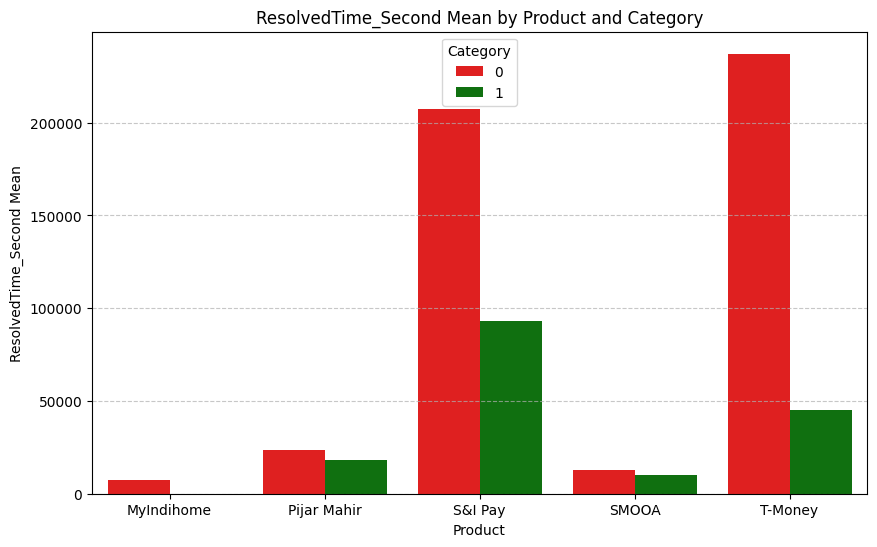

In [ ]:
# ResolvedTime_Second Mean by Product and Category
palette = {0: 'red', 1: 'green'}

plt.figure(figsize=(10, 6))
sns.barplot(x='Product', y='Mean_ResolvedTime_Second', hue='Category', data=average_product_category, palette=palette)
plt.title('ResolvedTime_Second Mean by Product and Category')
plt.xlabel('Product')
plt.ylabel('ResolvedTime_Second Mean')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

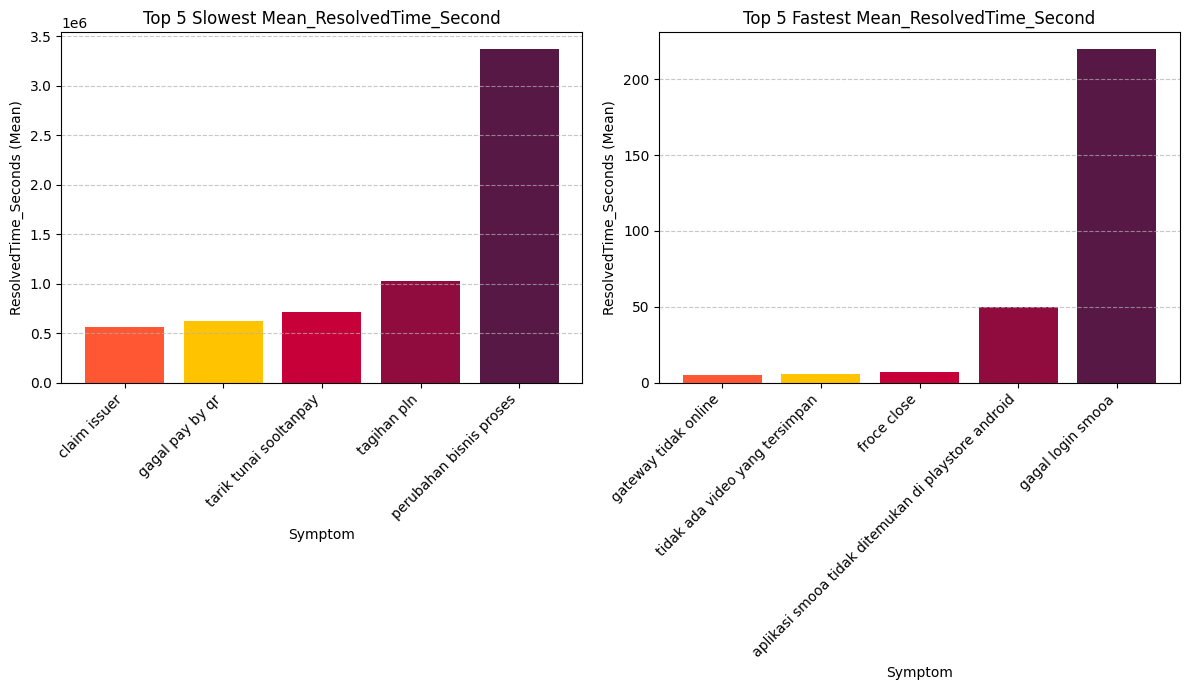

In [ ]:
# Plot for top 5 fastest and slowest symptoms (general)
colors = ['#FF5733', '#FFC300', '#C70039', '#900C3F', '#581845']

plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.bar(top_5_slowest_symptoms['Symptom'], top_5_slowest_symptoms['Mean_ResolvedTime_Second'], color=colors)
plt.xlabel('Symptom')
plt.ylabel('ResolvedTime_Seconds (Mean)')
plt.title('Top 5 Slowest Mean_ResolvedTime_Second')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(top_5_fastest_symptoms['Symptom'], top_5_fastest_symptoms['Mean_ResolvedTime_Second'], color=colors)
plt.xlabel('Symptom')
plt.ylabel('ResolvedTime_Seconds (Mean)')
plt.title('Top 5 Fastest Mean_ResolvedTime_Second')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Functions for visualization
def plot_top_symptoms(top_fastest_df, top_slowest_df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].barh(top_fastest_df['Symptom'], top_fastest_df['Mean_ResolvedTime_Second'], color='skyblue')
    axes[0].set_xlabel('ResolvedTime_Seconds (Mean)')
    axes[0].set_title('Top 5 Fastest Symptoms')
    axes[0].grid(True)
    axes[0].invert_yaxis()
    axes[0].grid(axis='y', linestyle='--', alpha=0.2)

    axes[1].barh(top_slowest_df['Symptom'], top_slowest_df['Mean_ResolvedTime_Second'], color='coral')
    axes[1].set_xlabel('ResolvedTime_Seconds (Mean)')
    axes[1].set_title('Top 5 Slowest Symptoms')
    axes[1].grid(True)
    axes[1].invert_yaxis()
    axes[1].grid(axis='y', linestyle='--', alpha=0.2)


    plt.tight_layout()
    plt.show()

def plot_symptom_categories(top_fastest_df, top_slowest_df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    def plot_single_category(ax, df, title):
        # Category 0 (limegreen)
        bar1 = ax.barh(df['Symptom'], df['Total_Category_0'], color='coral', label='Total_Category_0')

        # Category 1 (coral)
        bar2 = ax.barh(df['Symptom'], df['Total_Category_1'], left=df['Total_Category_0'], color='limegreen', label='Total_Category_1')

        for b1, b2 in zip(bar1, bar2):
            x1 = b1.get_width()
            x2 = b2.get_width()
            total = x1 + x2
            percentage1 = x1 / total * 100
            percentage2 = x2 / total * 100

            if percentage1 == 100:
                ax.text(x1 / 2, b1.get_y() + b1.get_height() / 2, f'{percentage1:.0f}%', ha='center', va='center', color='white')
            elif percentage2 == 100:
                ax.text(x1 + x2 / 2, b2.get_y() + b2.get_height() / 2, f'{percentage2:.0f}%', ha='center', va='center', color='white')
            else:
                ax.text(x1 / 2, b1.get_y() + b1.get_height() / 2, f'{percentage1:.1f}%', ha='center', va='center')
                ax.text(x1 + x2 / 2, b2.get_y() + b2.get_height() / 2, f'{percentage2:.1f}%', ha='center', va='center')

        ax.set_xlabel('Count')
        ax.set_title(title)
        ax.grid(axis='y', linestyle='--', alpha=0.2)
        ax.legend()
        ax.invert_yaxis()
        ax.grid(True)

    plot_single_category(axes[0], top_fastest_df, 'Top 5 Fastest Symptoms - Category Counts')
    plot_single_category(axes[1], top_slowest_df, 'Top 5 Slowest Symptoms - Category Counts')

    plt.tight_layout()
    plt.show()

### Pijar Mahir

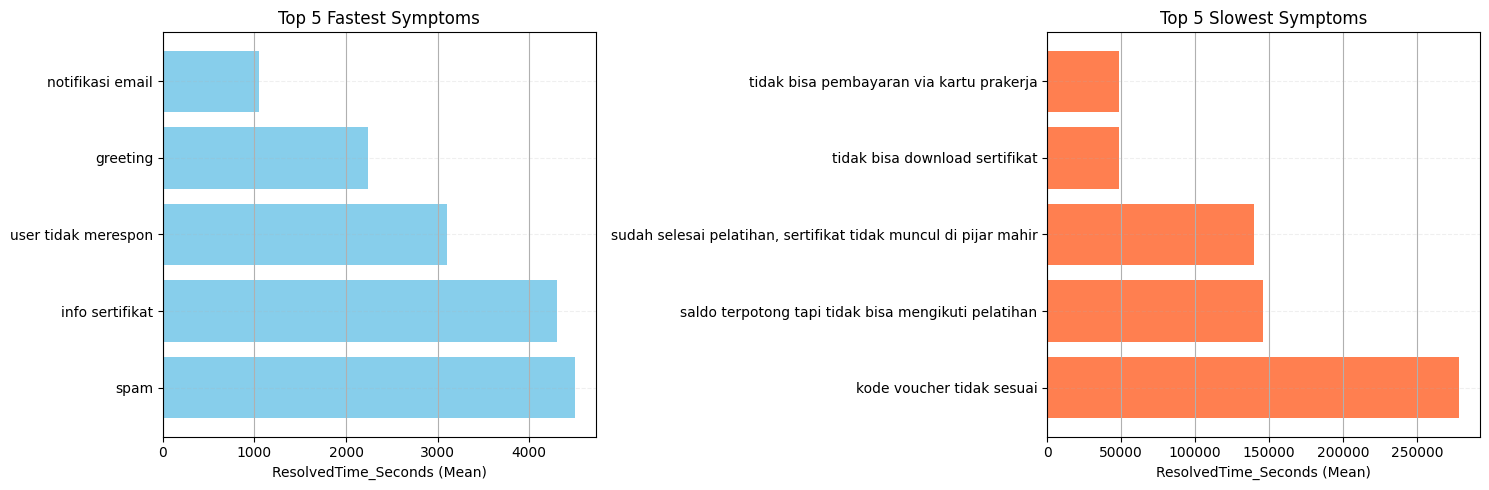

In [ ]:
plot_top_symptoms(top_5_fastest_pijar_mahir, top_5_slowest_pijar_mahir)

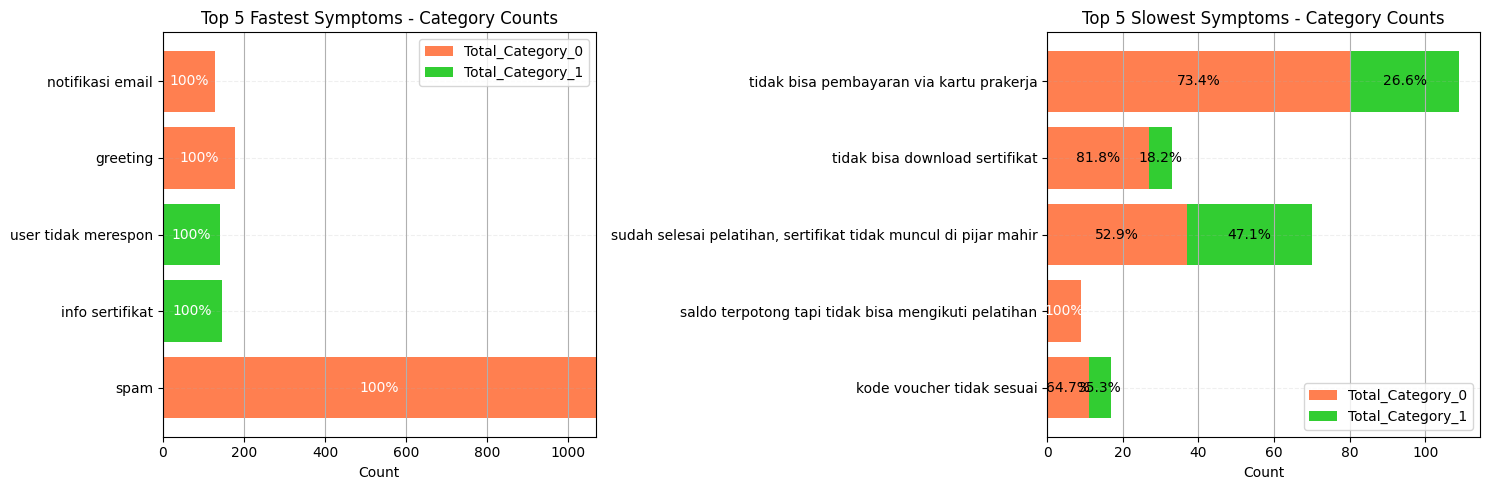

In [ ]:
plot_symptom_categories(top_5_fastest_pijar_mahir, top_5_slowest_pijar_mahir)

### S&I Pay

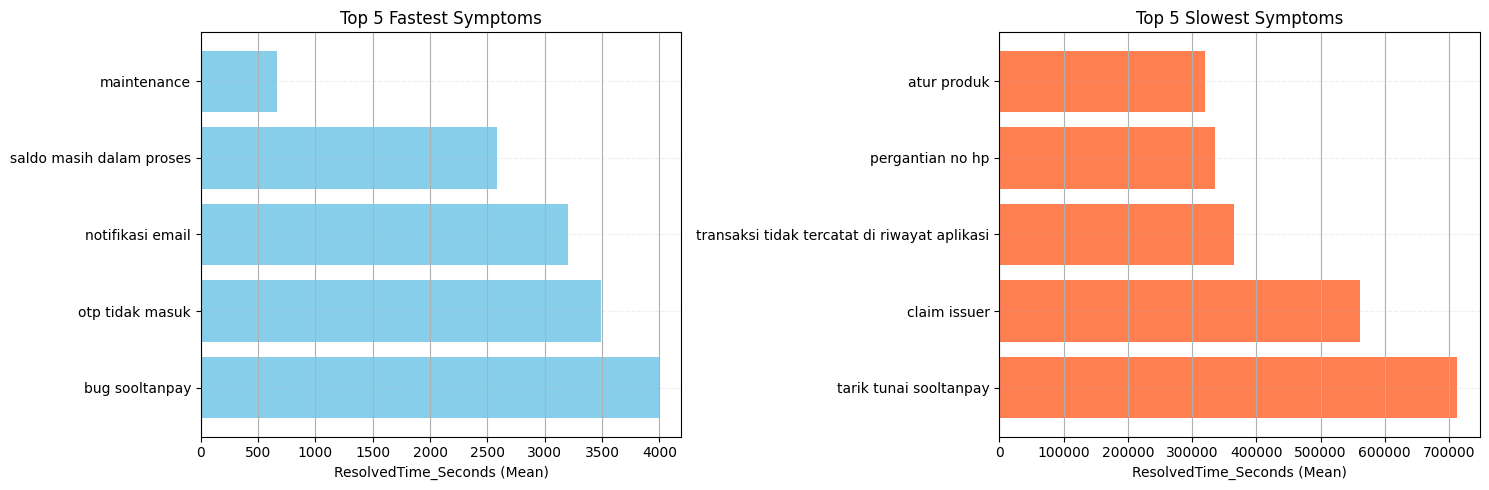

In [ ]:
plot_top_symptoms(top_5_fastest_s_and_i_pay, top_5_slowest_s_and_i_pay)

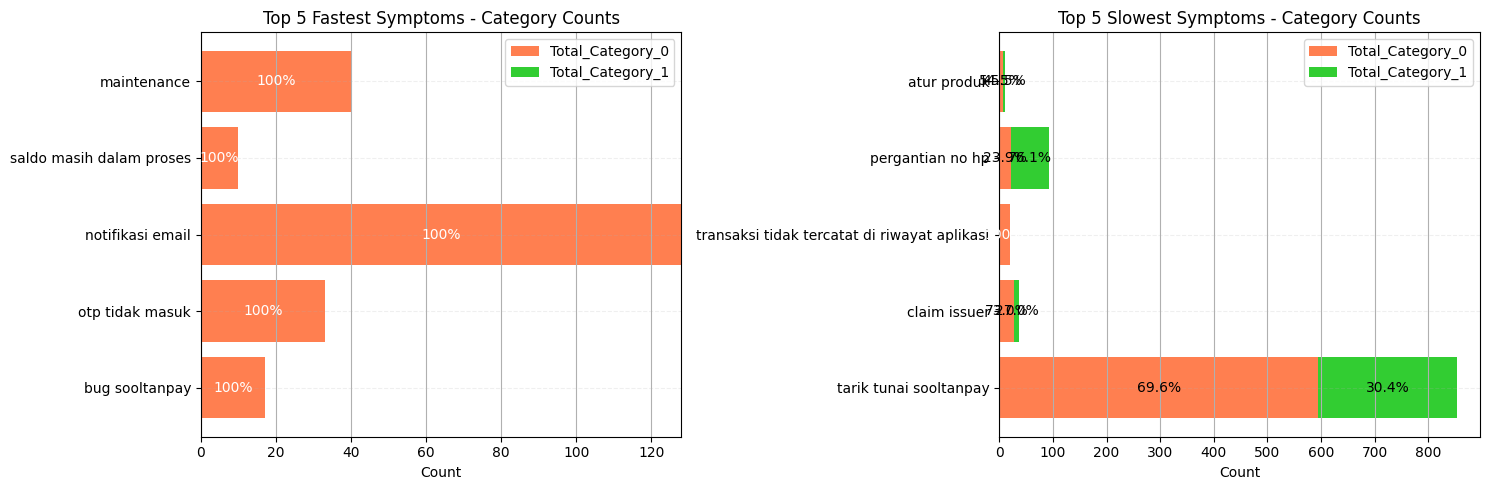

In [ ]:
plot_symptom_categories(top_5_fastest_s_and_i_pay, top_5_slowest_s_and_i_pay)

### T-Money

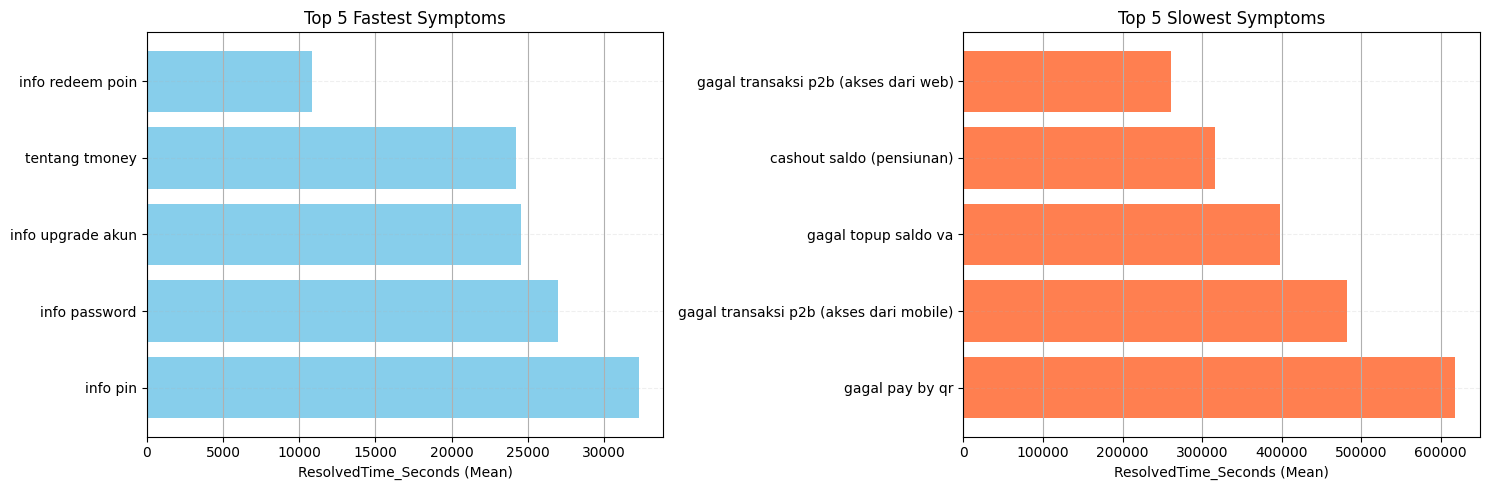

In [ ]:
plot_top_symptoms(top_5_fastest_t_money, top_5_slowest_t_money)

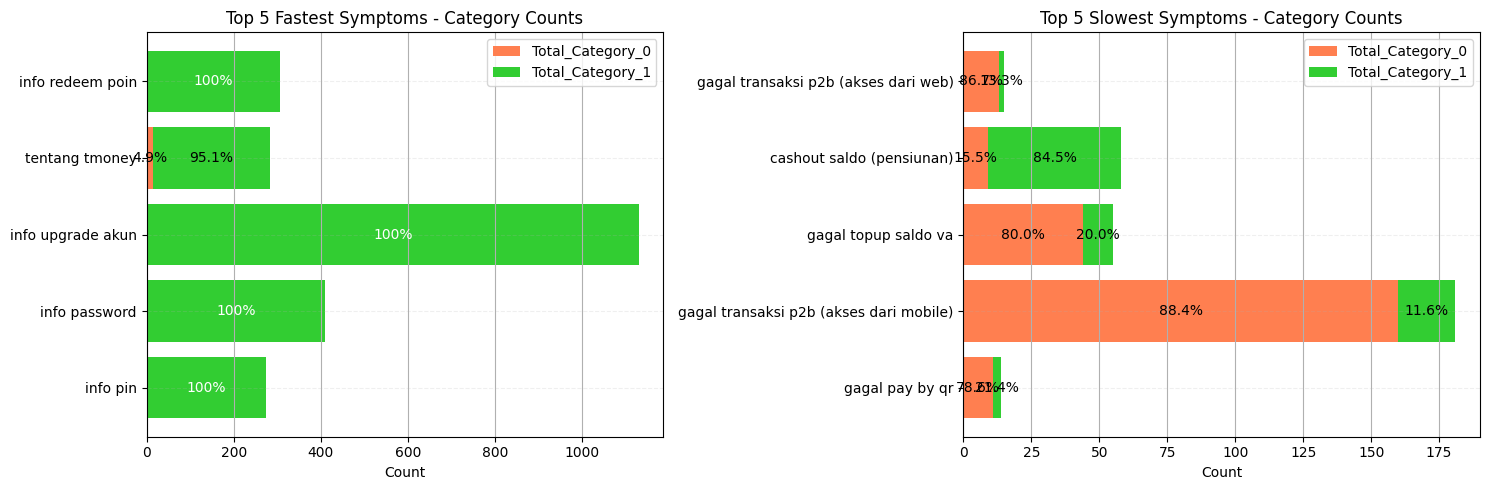

In [ ]:
plot_symptom_categories(top_5_fastest_t_money, top_5_slowest_t_money)

### SMOOA

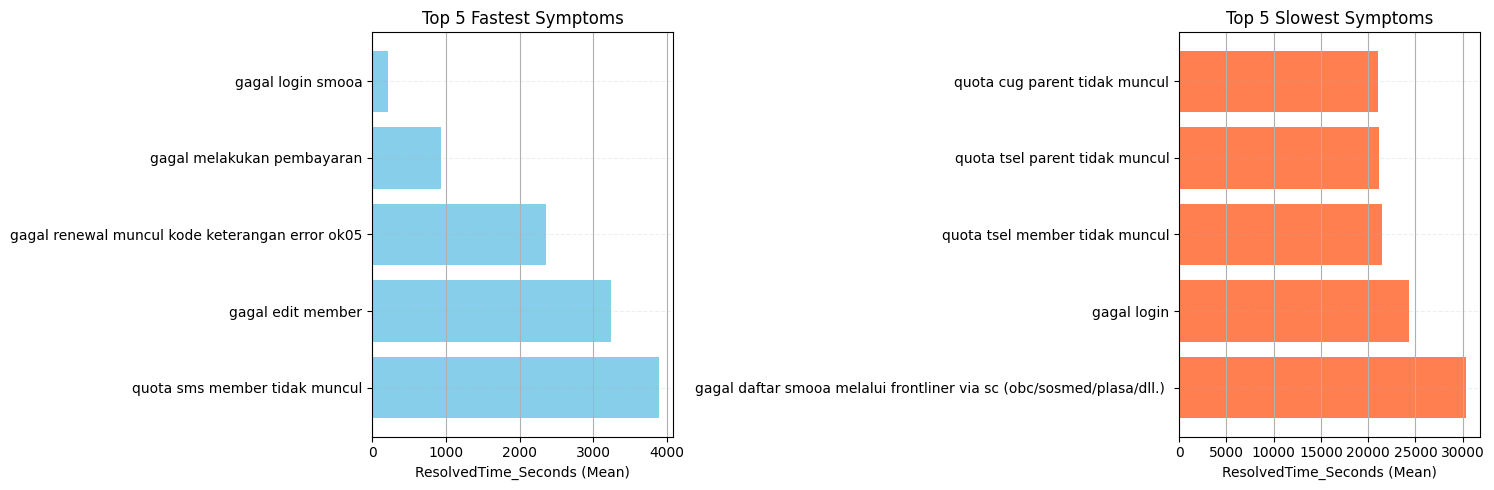

In [ ]:
plot_top_symptoms(top_5_fastest_SMOOA, top_5_slowest_SMOOA)

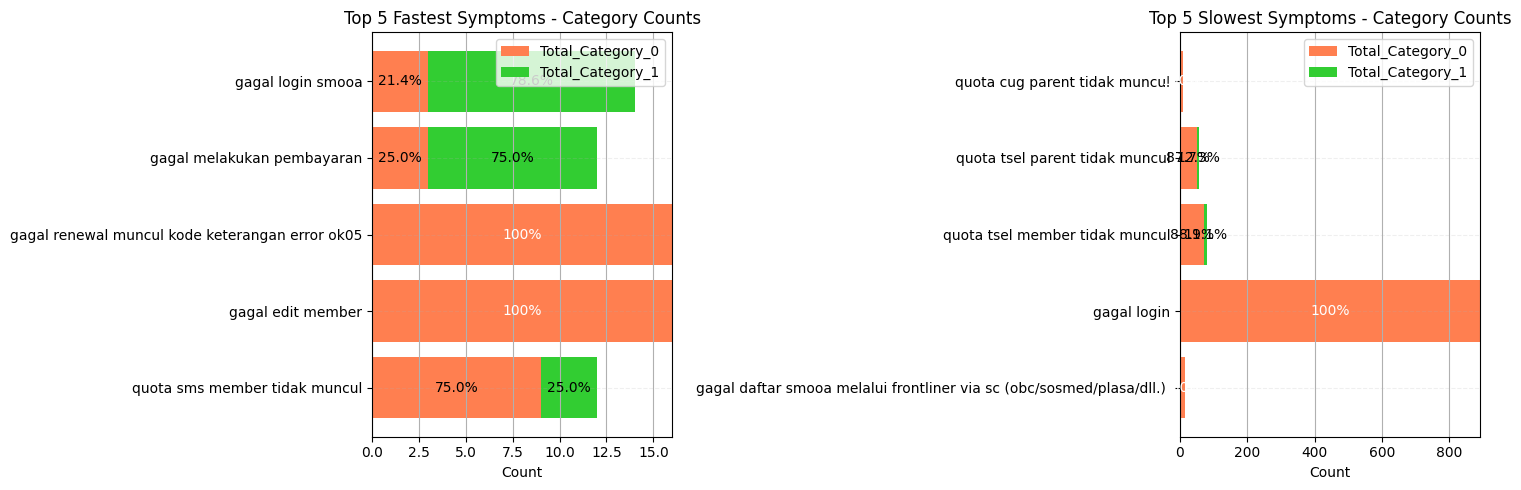

In [ ]:
plot_symptom_categories(top_5_fastest_SMOOA, top_5_slowest_SMOOA)

### MyIndihome

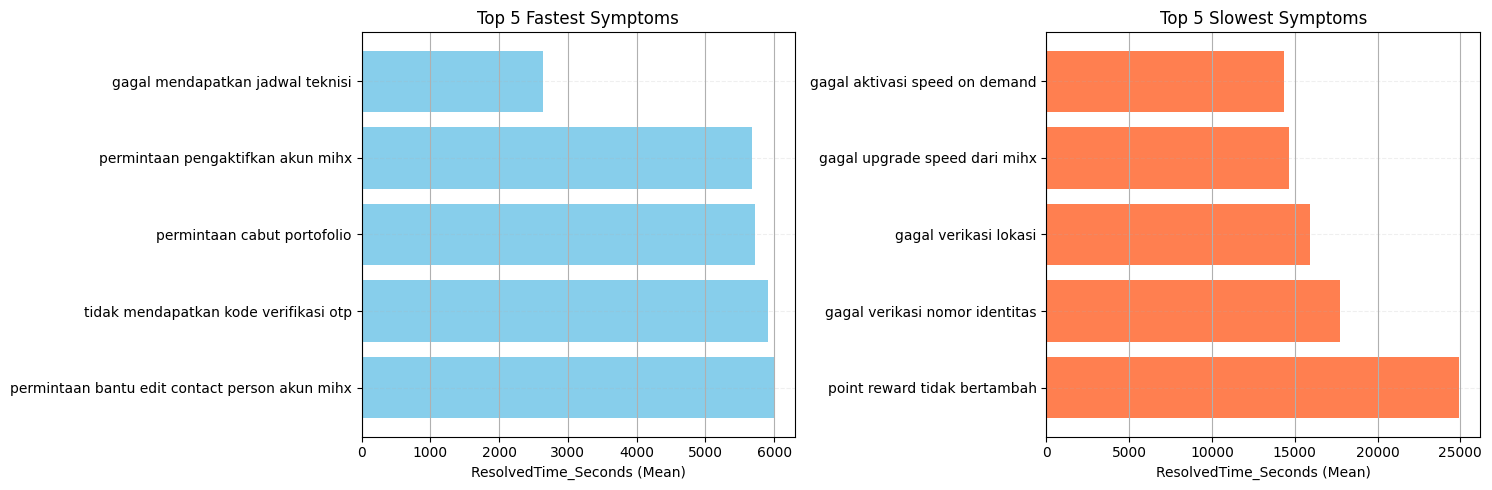

In [ ]:
plot_top_symptoms(top_5_fastest_MyIndihome, top_5_slowest_MyIndihome)

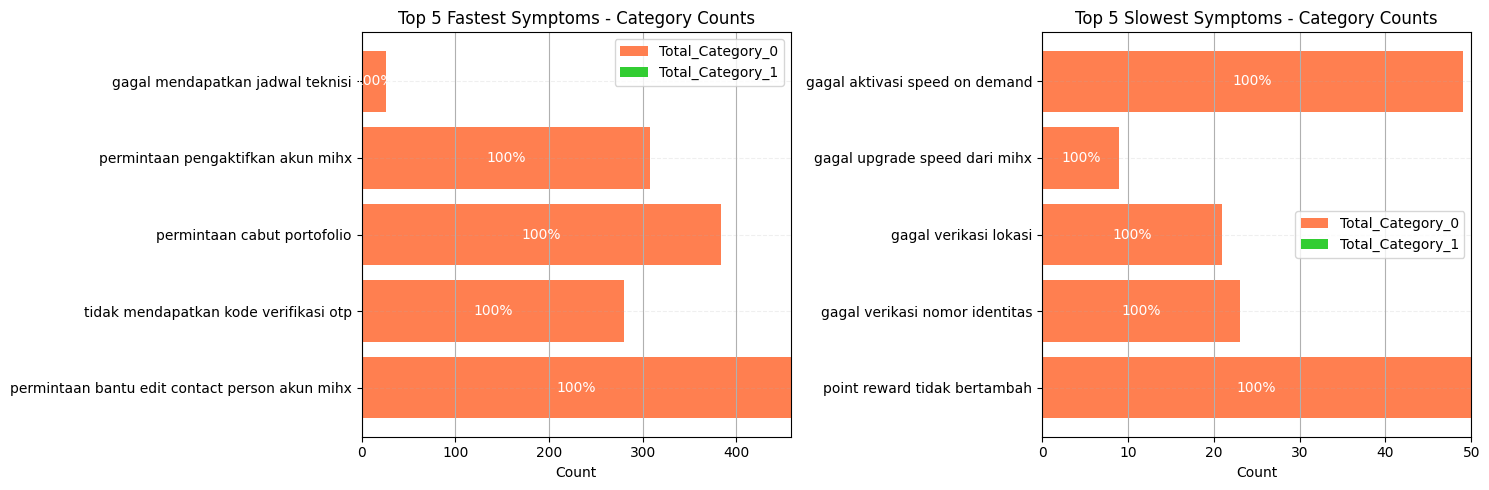

In [ ]:
plot_symptom_categories(top_5_fastest_MyIndihome, top_5_slowest_MyIndihome)

### Category-ResolvedTime_Second Mean

In [ ]:
mean_time_per_category.reset_index(inplace=True)
mean_time_per_category.rename(columns={'index': 'Category'}, inplace=True)

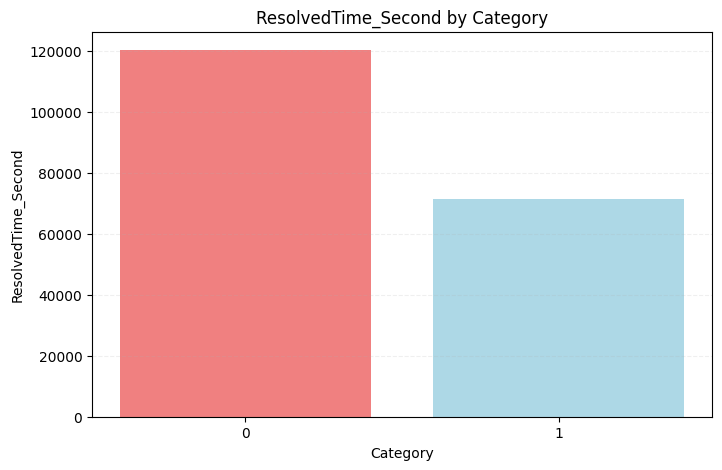

In [ ]:
# Plot for ResolvedTime_Second by Category
width = 0.8
x = range(len(mean_time_per_category))

plt.figure(figsize=(8, 5))
plt.bar(x, mean_time_per_category['ResolvedTime_Second'], width=width, color=['lightcoral', 'lightblue'])
plt.xlabel('Category')
plt.ylabel('ResolvedTime_Second')
plt.title('ResolvedTime_Second by Category')
plt.xticks(x, mean_time_per_category['Category'])
plt.grid(axis='y', linestyle='--', alpha=0.2)

plt.show()

## Frequency and Severity **(In Progress)**

## Category Comparison Visualization (Cleaned)

### Category vs Product

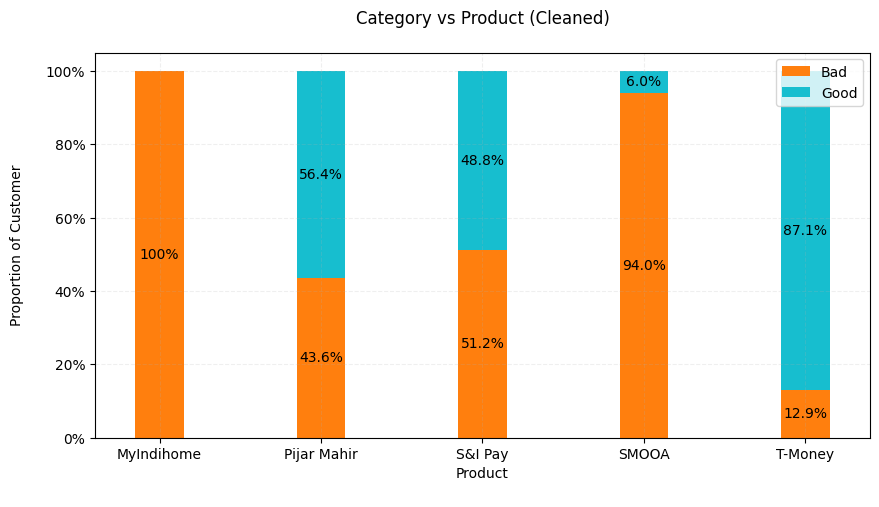

In [ ]:
cleaned_category_product = busy_days.groupby(['Product','Category']).size().unstack()
cleaned_category_product.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(cleaned_category_product, colors, y_label='Proportion of Customer', x_label='Product', title='Category vs Product (Cleaned)')

### Category vs Status

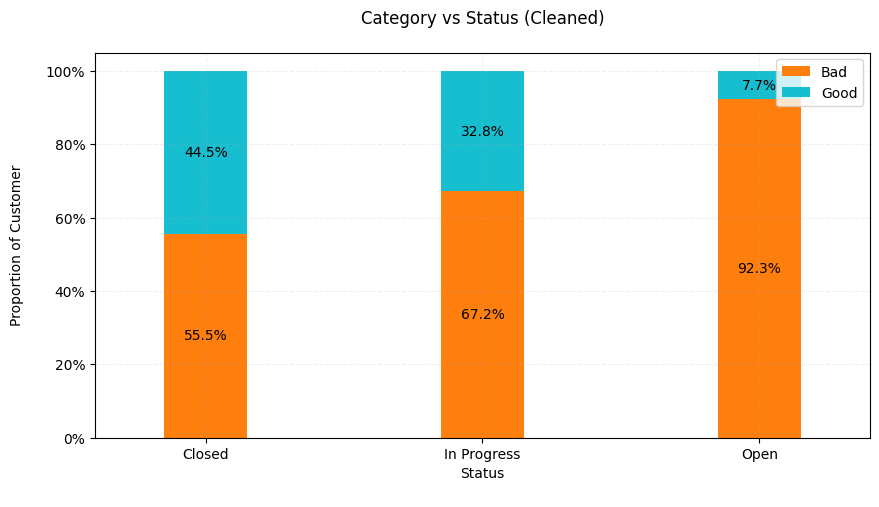

In [ ]:
cleaned_category_status = busy_days.groupby(['Status','Category']).size().unstack()
cleaned_category_status.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(cleaned_category_status, colors, y_label='Proportion of Customer', x_label='Status', title='Category vs Status (Cleaned)')

### Category vs Channel

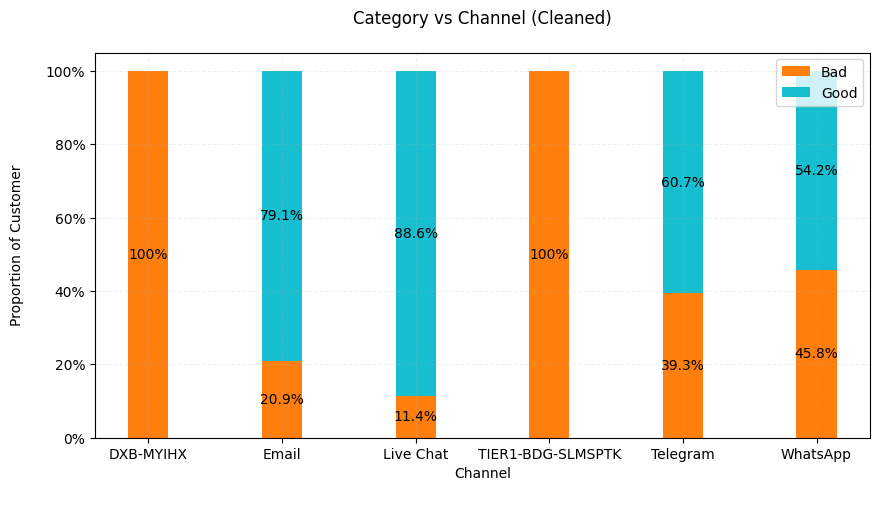

In [ ]:
cleaned_category_channel = busy_days.groupby(['Channel','Category']).size().unstack()
cleaned_category_channel.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(cleaned_category_channel, colors, y_label='Proportion of Customer', x_label='Channel', title='Category vs Channel (Cleaned)')

### Category vs Month

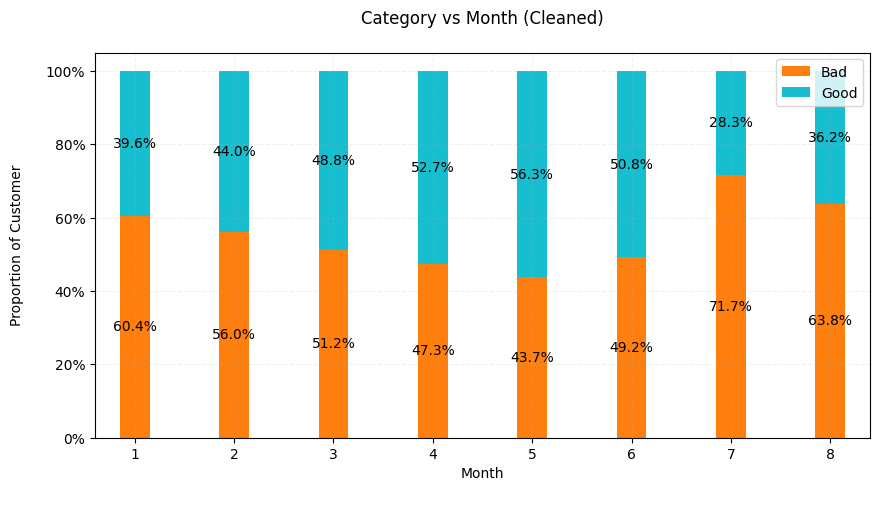

In [ ]:
cleaned_category_month = busy_days.groupby(['Month','Category']).size().unstack()
cleaned_category_month.rename(columns={0:'Bad', 1:'Good'}, inplace=True)
colors  = ['#ff7f0e','#17becf']
plot_stack1(cleaned_category_month, colors, y_label='Proportion of Customer', x_label='Month', title='Category vs Month (Cleaned)')

# Forecasting

In [ ]:
# Use original dataset (df) for forecasting
day_counts_original = df.resample('D', on='Periode').agg({'Category': ['count', lambda x: x.eq(0).sum(), lambda x: x.eq(1).sum()]})

day_counts_original.columns = ['Total_Data', 'Category_0', 'Category_1']
day_counts_original['Day'] = day_counts_original.index.strftime('%A')
day_counts_original.reset_index(inplace=True)

print(day_counts_original)

       Periode  Total_Data  Category_0  Category_1        Day
0   2023-01-01         305         251          54     Sunday
1   2023-01-02         403         293         110     Monday
2   2023-01-03         298         169         129    Tuesday
3   2023-01-04         364         257         107  Wednesday
4   2023-01-05         316         201         115   Thursday
..         ...         ...         ...         ...        ...
230 2023-08-19          97          41          56   Saturday
231 2023-08-20         109          68          41     Sunday
232 2023-08-21         381         293          88     Monday
233 2023-08-22         192         109          83    Tuesday
234 2023-08-23          55          24          31  Wednesday

[235 rows x 5 columns]


## SARIMAX

### Data Cleaning

In [ ]:
fc_data = day_counts_original.drop(['Category_0', 'Category_1', 'Day'], axis=1)
# fc_data = day_counts.drop(['Total_Data', 'Category_1', 'Day'], axis=1)
# fc_data = day_counts.drop(['Category_0', 'Total_Data', 'Day'], axis=1)

In [ ]:
# Make the DATE's value as an index, lag, or t
fc_data.set_index('Periode', inplace=True)

In [ ]:
fc_data

,Total_Data
Periode,
2023-01-01,305
2023-01-02,403
2023-01-03,298
2023-01-04,364
2023-01-05,316
...,...
2023-08-19,97
2023-08-20,109
2023-08-21,381


### Original Data Plot

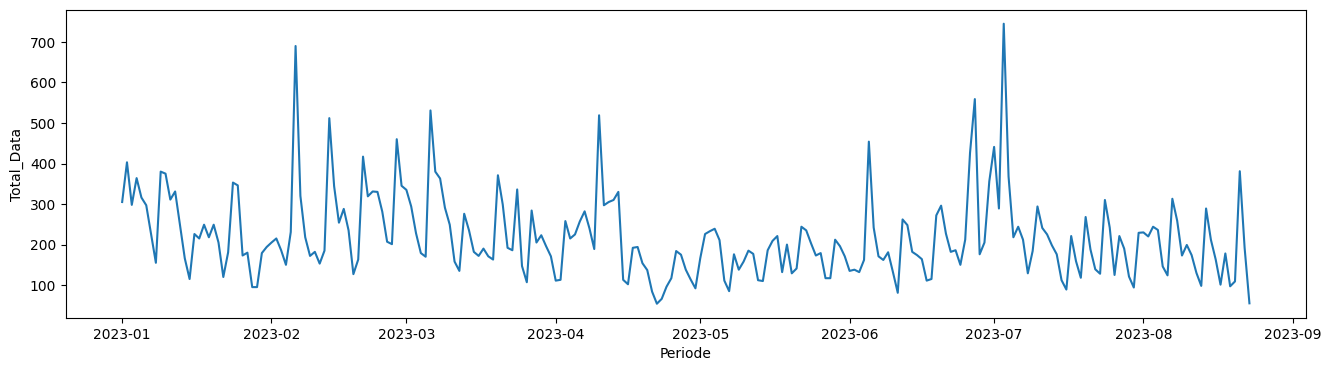

In [ ]:
plt.figure(figsize=(16, 4))
sns.lineplot(data=fc_data, x=fc_data.index,y=fc_data.Total_Data)
plt.show()

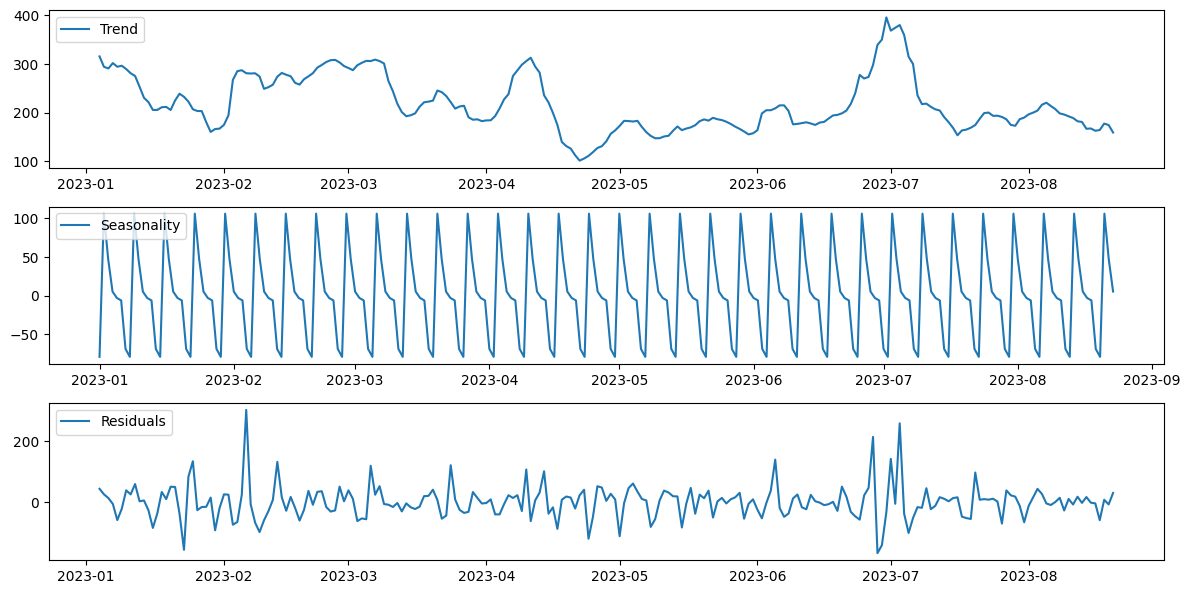

In [ ]:
# Do the decomposition
decomposition = sm.tsa.seasonal_decompose(fc_data['Total_Data'], model='additive')

# Decomposition components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12, 8))
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Define the window
fc_data['rollMean'] = fc_data.Total_Data.rolling(window=7).mean()
fc_data['rollStd'] = fc_data.Total_Data.rolling(window=7).std()

<Axes: xlabel='Periode', ylabel='Total_Data'>

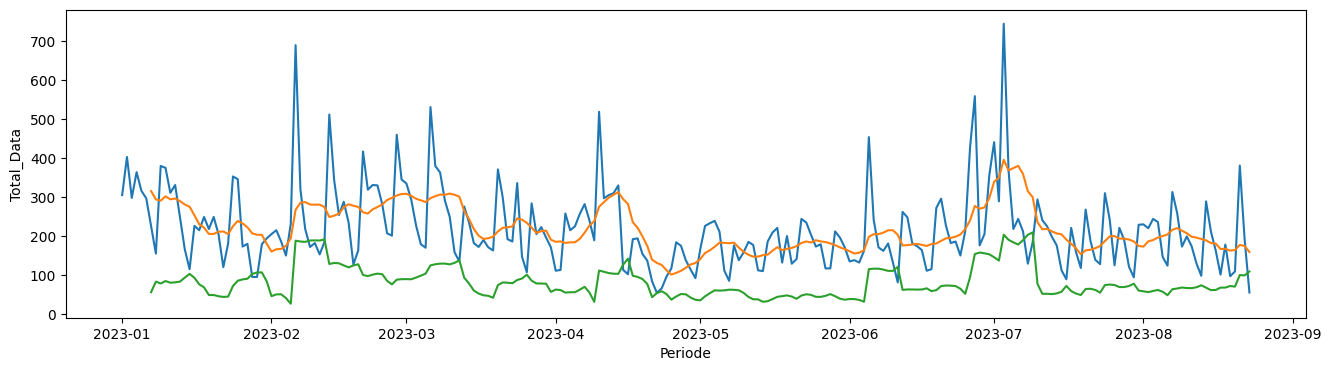

In [ ]:
# Plot the rollMean and rollStd
plt.figure(figsize = (16,4))
sns.lineplot(data=fc_data, x=fc_data.index, y=fc_data.Total_Data)
sns.lineplot(data=fc_data, x=fc_data.index, y=fc_data.rollMean)
sns.lineplot(data=fc_data, x=fc_data.index, y=fc_data.rollStd)

### Stationarity Test

Null Hypothesis = The data is non stationary

In [ ]:
adfTest = adfuller(fc_data['Total_Data'],autolag = "AIC",) # Use AIC for choosing the number of lags
adfTest

(-2.9846446760102245,
 0.03635349077785598,
 14,
 220,
 {'1%': -3.4604283689894815,
  '5%': -2.874768966942149,
  '10%': -2.57382076446281},
 2538.6893187374494)

In [ ]:
stats_adf_test = pd.Series(adfTest[0:4],index=['Test Statistic', 'p-value','#lags used','number of observations used'])
stats_adf_test

Test Statistic                  -2.984645
p-value                          0.036353
#lags used                      14.000000
number of observations used    220.000000
dtype: float64

p-value is lower than 0.05, Null Hypothesis can be rejected

In [ ]:
# Drop the unnecessary columns
fc_data = fc_data.drop(columns=['rollMean', 'rollStd'])

### Determine p d q order

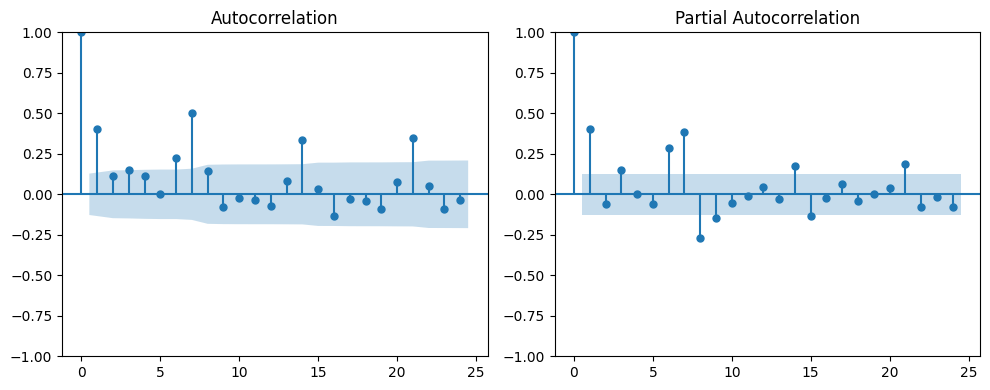

In [ ]:
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(fc_data['Total_Data'], ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
ax2 = plt.subplot(122)
plot_pacf(fc_data['Total_Data'], ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
# Test the p d q order
fc_data.index = pd.to_datetime(fc_data.index)
fc_data = fc_data.asfreq('D')
ar_model = SARIMAX(fc_data['Total_Data'], order=(1,0,1)).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Total_Data   No. Observations:                  235
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1410.763
Date:                Tue, 31 Oct 2023   AIC                           2827.526
Time:                        16:09:18   BIC                           2837.905
Sample:                    01-01-2023   HQIC                          2831.710
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.005    202.940      0.000       0.987       1.007
ma.L1         -0.8122      0.039    -20.810      0.000      -0.889      -0.736
sigma2      9473.0882    539.790     17.550      0.000    8415.120    1.05e+04
===================================================================================
Ljung-Box (L1) (Q):                  11.40   Jarque-Bera (JB):               334.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             1.62
Prob(H) (two-sided):                  0.74   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train and Test the Data

In [ ]:
# Use 21 steps or 3 weeks data for test and train
print(fc_data.shape)
train = fc_data['Total_Data'].iloc[:-21]
test = fc_data['Total_Data'].iloc[-21:]
print(train.shape, test.shape)

(235, 1)
(214,) (21,)


In [ ]:
print(test.index, train.index)

DatetimeIndex(['2023-08-03', '2023-08-04', '2023-08-05', '2023-08-06',
               '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10',
               '2023-08-11', '2023-08-12', '2023-08-13', '2023-08-14',
               '2023-08-15', '2023-08-16', '2023-08-17', '2023-08-18',
               '2023-08-19', '2023-08-20', '2023-08-21', '2023-08-22',
               '2023-08-23'],
              dtype='datetime64[ns]', name='Periode', freq='D') DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-07-24', '2023-07-25', '2023-07-26', '2023-07-27',
               '2023-07-28', '2023-07-29', '2023-07-30', '2023-07-31',
               '2023-08-01', '2023-08-02'],
              dtype='datetime64[ns]', name='Periode', length=214, freq='D')


In [ ]:
test_df = test.to_frame()
train_df = train.to_frame()

In [ ]:
# SARIMAX
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)  # Seasonal order (P, D, Q, m)
model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1

pred_sarimax = results.predict(start=start, end=end, typ='levels')

# Convert predictions into appropriate indices
pred_sarimax.index = fc_data.index[start:end + 1]
# print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


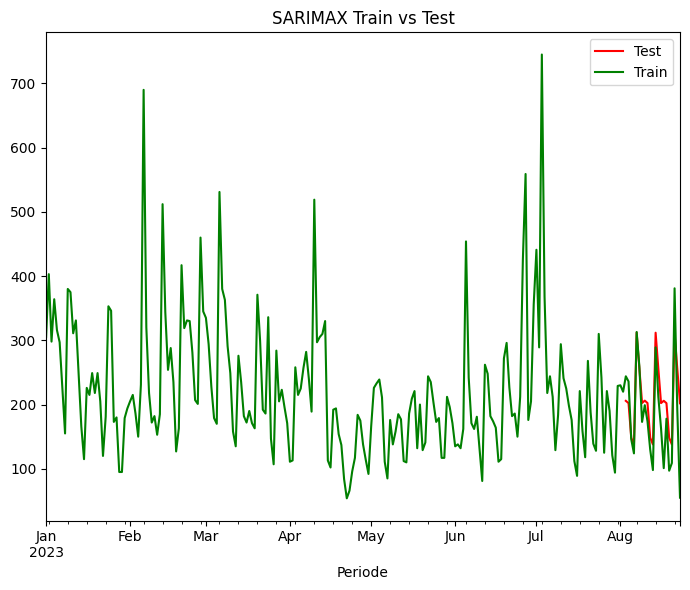

In [ ]:
plt.figure(figsize=(7, 6))
pred_sarimax.plot(legend=True, label='Test', color='red')
fc_data['Total_Data'].plot(legend=True, label='Train', color='green')
plt.title('SARIMAX Train vs Test')

plt.tight_layout()
plt.show()

In [ ]:
train_fc= fc_data['Total_Data']
train_fc

Periode
2023-01-01    305
2023-01-02    403
2023-01-03    298
2023-01-04    364
2023-01-05    316
             ... 
2023-08-19     97
2023-08-20    109
2023-08-21    381
2023-08-22    192
2023-08-23     55
Freq: D, Name: Total_Data, Length: 235, dtype: int64

### Forecast Future Value

In [ ]:
# Fit the SARIMAX model to the log-transformed data
sarimax_model = SARIMAX(train_fc, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
fitted_model = sarimax_model.fit()

# Get the forecasts from the SARIMAX model in log-transformed units
forecast_data_sarimax = fitted_model.forecast(steps=21)

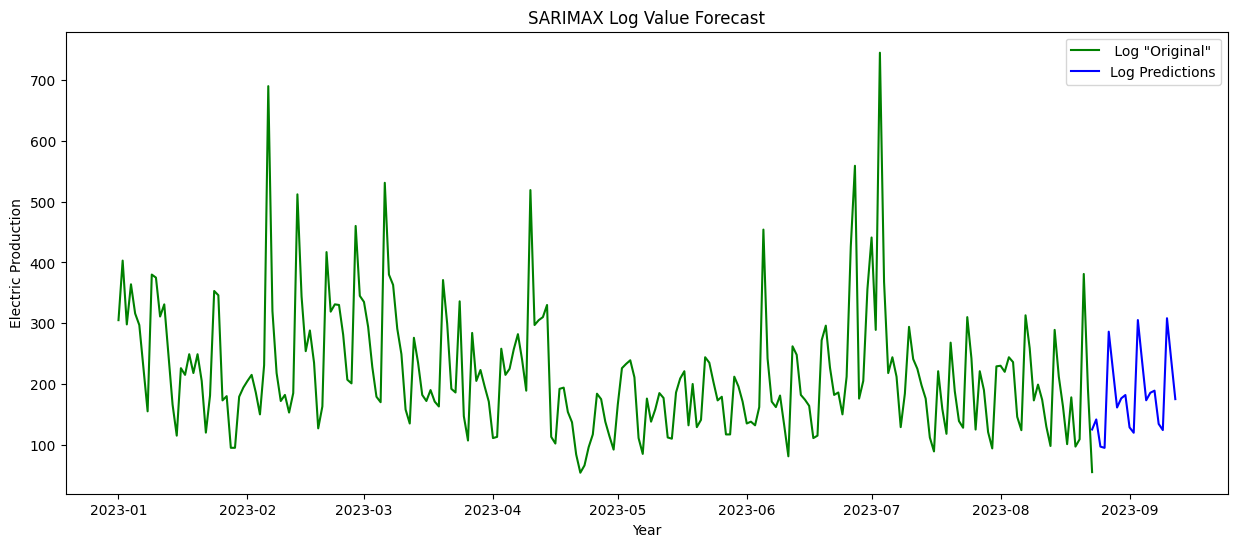

In [ ]:
# Predictions
predictions_SARIMAX = fitted_model.get_forecast(steps=len(test))

# Confidence intervals for the predictions
pred_confidence = predictions_SARIMAX.conf_int()

# Extend the time index for predictions
future_index = pd.date_range(start=train_fc.index[-1], periods=len(test), freq='D')

# Visualize the original time series (log) and the predictions
plt.figure(figsize=(15, 6))
plt.plot(fc_data.index, fc_data['Total_Data'], label=' Log "Original"', color='green')
plt.plot(future_index, predictions_SARIMAX.predicted_mean, color='blue', label='Log Predictions')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMAX Log Value Forecast')
plt.legend()
plt.show()

In [ ]:
forecast_data_sarimax

2023-08-24    125.129597
2023-08-25    141.634503
2023-08-26     96.960234
2023-08-27     94.877382
2023-08-28    286.062911
2023-08-29    223.346417
2023-08-30    161.314178
2023-08-31    176.332061
2023-09-01    181.835706
2023-09-02    128.632175
2023-09-03    119.762537
2023-09-04    305.175180
2023-09-05    238.392320
2023-09-06    173.188095
2023-09-07    185.566680
2023-09-08    189.007258
2023-09-09    134.308784
2023-09-10    124.188732
2023-09-11    308.186734
2023-09-12    240.766500
2023-09-13    175.088940
Freq: D, Name: predicted_mean, dtype: float64

## Exponential Smoothing

### Forecast Future Value

In [ ]:
model = ExponentialSmoothing(fc_data['Total_Data'], seasonal='add', seasonal_periods=7, trend='add')

es_fit = model.fit()
forecast_es = es_fit.forecast(steps=21)

## Comparison

In [ ]:
# Statistical comparison
sarima_mae = mean_absolute_error(forecast_data_sarimax, pred_sarimax)
sarima_mse = mean_squared_error(forecast_data_sarimax, pred_sarimax)
sarima_rmse = np.sqrt(sarima_mse)
sarima_aic = fitted_model.aic

true_values = fc_data['Total_Data'].tail(21)
es_mae = mean_absolute_error(true_values, forecast_es)
es_mse = mean_squared_error(true_values, forecast_es)
es_rmse = np.sqrt(es_mse)
es_aic = es_fit.aic

In [ ]:
print("SARIMA MAE: ", sarima_mae)
print("Exponential Smoothing MAE: ", es_mae)

print("SARIMA MSE: ", sarima_mse)
print("Exponential Smoothing MSE: ", es_mse)

print("SARIMA RMSE: ", sarima_rmse)
print("Exponential Smoothing RMSE: ", es_rmse)

print("SARIMA AIC: ", sarima_aic)
print("Exponential Smoothing AIC: ", es_aic)

SARIMA MAE:  27.824330334648078
Exponential Smoothing MAE:  65.90084491074889
SARIMA MSE:  1110.0041736861049
Exponential Smoothing MSE:  5181.778581871444
SARIMA RMSE:  33.3167251344742
Exponential Smoothing RMSE:  71.98457183224363
SARIMA AIC:  2694.735559218778
Exponential Smoothing AIC:  2040.9428944124934


## Forecasting Result

Based on the MAE, MSE, AIC, and RMSE scores, SARIMAX has a better result

### Exponential Smoothing Result

In [ ]:
# Show the Exponential Smoothing result
print(forecast_es)

2023-08-24    132.851641
2023-08-25    135.085260
2023-08-26     75.670847
2023-08-27     60.894276
2023-08-28    247.952088
2023-08-29    167.933938
2023-08-30    108.492037
2023-08-31    123.092360
2023-09-01    125.325979
2023-09-02     65.911566
2023-09-03     51.134996
2023-09-04    238.192807
2023-09-05    158.174657
2023-09-06     98.732757
2023-09-07    113.333080
2023-09-08    115.566699
2023-09-09     56.152285
2023-09-10     41.375715
2023-09-11    228.433527
2023-09-12    148.415376
2023-09-13     88.973476
Freq: D, dtype: float64


### SARIMAX Result

In [ ]:
# Fit the SARIMAX result into dataframe
forecast_data_sarimax = pd.DataFrame(forecast_data_sarimax)

In [ ]:
forecast_data_sarimax['Periode'] = forecast_data_sarimax.index
forecast_data_sarimax = forecast_data_sarimax.reset_index(drop=True)
forecast_data_sarimax = forecast_data_sarimax.rename(columns={'predicted_mean': 'predicted_total_case'})

In [ ]:
# Show the result
forecast_data_sarimax['predicted_total_case'] = forecast_data_sarimax['predicted_total_case'].round()
forecast_data_sarimax

,predicted_total_case,Periode
0,125.0,2023-08-24
1,142.0,2023-08-25
2,97.0,2023-08-26
3,95.0,2023-08-27
4,286.0,2023-08-28
5,223.0,2023-08-29
6,161.0,2023-08-30
7,176.0,2023-08-31
8,182.0,2023-09-01
9,129.0,2023-09-02


In [ ]:
# Total predicted case by day
forecast_data_sarimax['Day_Name'] = forecast_data_sarimax['Periode'].dt.strftime('%A')
total_cases_per_day = forecast_data_sarimax.groupby('Day_Name')['predicted_total_case'].sum().reset_index()
total_cases_per_day['Day_Name'] = pd.Categorical(total_cases_per_day['Day_Name'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
total_cases_per_day = total_cases_per_day.sort_values('Day_Name')

total_cases_per_day

,Day_Name,predicted_total_case
1,Monday,899.0
5,Tuesday,702.0
6,Wednesday,509.0
4,Thursday,487.0
0,Friday,513.0
2,Saturday,360.0
3,Sunday,339.0
